<a href="https://colab.research.google.com/github/akhil2303a52315/2303A52315-hub-GAI/blob/main/smart_grid_final_for_research_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

"""
================================================================================
Smart Grid Real-Time Load Monitoring - IEEE Research Paper Version
================================================================================
Enhanced Analysis with Top 5 Models, K-Fold Validation, and Comprehensive Metrics
Author: Research Team
Date: December 2025
================================================================================
"""

# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND IMPORTS
# ============================================================================

import warnings
warnings.simplefilter('ignore')

# Install required packages
import subprocess
import sys

def install_packages():
    """Install required packages silently"""
    packages = ['kagglehub', 'scikit-learn', 'tensorflow', 'xgboost', 'lightgbm', 'catboost']
    for package in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

# Uncomment below line if running for the first time
install_packages()

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             mean_absolute_percentage_error, explained_variance_score,
                             median_absolute_error, max_error)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              StackingRegressor, VotingRegressor, ExtraTreesRegressor)
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import time
import json
import os
import joblib
from datetime import datetime
from scipy import stats
import pickle

# Set style for professional plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Configuration
CONFIG = {
    'test_size': 0.2,
    'k_folds': 5,
    'epochs': 50,
    'batch_size': 128,
    'patience': 7,
    'n_estimators': 100,
    'max_depth': 8,
    'learning_rate': 0.001,
    'validation_split': 0.2
}

# Check GPU
GPU_AVAILABLE = len(tf.config.list_physical_devices('GPU')) > 0
if GPU_AVAILABLE:
    print("✓ GPU Detected and Enabled")
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("✗ GPU Not Available - Using CPU")

print("="*80)
print("SMART GRID REAL-TIME LOAD MONITORING - IEEE RESEARCH VERSION")
print("="*80)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Execution Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random State: {RANDOM_STATE}")
print(f"K-Folds: {CONFIG['k_folds']}")
print("="*80)

# Create directories
os.makedirs('ieee_models', exist_ok=True)
os.makedirs('ieee_results', exist_ok=True)
os.makedirs('ieee_plots', exist_ok=True)

# ============================================================================
# SECTION 3: DATA LOADING & INITIAL EXPLORATION
# ============================================================================

print("\n" + "="*80)
print("PHASE 1: DATA LOADING & INITIAL EXPLORATION")
print("="*80)

start_time = time.time()

# Load dataset
print("\n📂 Loading Dataset...")
path = kagglehub.dataset_download("ziya07/smart-grid-real-time-load-monitoring-dataset")
csv_files = [os.path.join(root, file) for root, _, files in os.walk(path)
             for file in files if file.endswith('.csv')]
df_original = pd.read_csv(csv_files[0])

print(f"✓ Dataset Loaded Successfully")
print(f"  • Shape: {df_original.shape[0]:,} rows × {df_original.shape[1]} columns")
print(f"  • Memory Usage: {df_original.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display initial data info
print("\n📊 Initial Data Overview:")
print("-" * 80)
print(df_original.head())
print("\n📊 Data Types:")
print(df_original.dtypes)
print("\n📊 Statistical Summary (Before Preprocessing):")
print(df_original.describe())

# Missing values
print("\n📊 Missing Values Analysis:")
missing_data = pd.DataFrame({
    'Column': df_original.columns,
    'Missing_Count': df_original.isnull().sum(),
    'Missing_Percentage': (df_original.isnull().sum() / len(df_original) * 100).round(2)
})
print(missing_data[missing_data['Missing_Count'] > 0])
if missing_data['Missing_Count'].sum() == 0:
    print("✓ No missing values found")

# ============================================================================
# SECTION 4: DATA PREPROCESSING & CLEANING
# ============================================================================

print("\n" + "="*80)
print("PHASE 2: DATA PREPROCESSING & CLEANING")
print("="*80)

df_processed = df_original.copy()

# 1. Handle Categorical Variables
print("\n🔧 Step 1: Encoding Categorical Variables...")
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

if categorical_cols:
    print(f"  • Found {len(categorical_cols)} categorical columns: {categorical_cols}")
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
    print(f"  ✓ Encoded {len(categorical_cols)} categorical variables")
else:
    print("  • No categorical variables found")

# 2. kWh to Watts Conversion
print("\n🔧 Step 2: Unit Conversion (kWh → Watts)...")
conversion_log = []
for col in df_processed.columns:
    if any(keyword in col.lower() for keyword in ['kw', 'power', 'load', 'consumption']):
        if df_processed[col].dtype in [np.float64, np.int64]:
            max_val = df_processed[col].max()
            if max_val < 1000:  # Likely in kW
                old_mean = df_processed[col].mean()
                df_processed[col] = df_processed[col] * 1000
                new_mean = df_processed[col].mean()
                conversion_log.append({
                    'Column': col,
                    'Old_Mean': f"{old_mean:.2f}",
                    'New_Mean': f"{new_mean:.2f}",
                    'Conversion': 'kW → W (×1000)'
                })

if conversion_log:
    print(pd.DataFrame(conversion_log).to_string(index=False))
else:
    print("  • No conversions needed")

# 3. Identify Target Variable
print("\n🔧 Step 3: Identifying Target Variable...")
target_candidates = [col for col in df_processed.columns if 'consumption' in col.lower()]
if target_candidates:
    target_col = target_candidates[0]
    print(f"  ✓ Target Variable: '{target_col}'")
else:
    # Use last numerical column
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    target_col = numerical_cols[-1]
    print(f"  ✓ Target Variable (default): '{target_col}'")

print(f"  • Target Statistics:")
print(f"    - Mean: {df_processed[target_col].mean():.2f} W")
print(f"    - Std: {df_processed[target_col].std():.2f} W")
print(f"    - Min: {df_processed[target_col].min():.2f} W")
print(f"    - Max: {df_processed[target_col].max():.2f} W")

# 4. Feature Engineering
print("\n🔧 Step 4: Feature Engineering...")
numerical_cols = [col for col in df_processed.select_dtypes(include=[np.number]).columns
                  if col != target_col]

voltage_cols = [col for col in numerical_cols if 'volt' in col.lower()]
current_cols = [col for col in numerical_cols if 'curr' in col.lower()]

feature_count = 0
if voltage_cols and current_cols:
    df_processed['Power_VI'] = df_processed[voltage_cols[0]] * df_processed[current_cols[0]]
    print(f"  ✓ Created 'Power_VI' (Voltage × Current)")
    feature_count += 1

# Add statistical features
if len(numerical_cols) >= 3:
    df_processed['Features_Mean'] = df_processed[numerical_cols].mean(axis=1)
    df_processed['Features_Std'] = df_processed[numerical_cols].std(axis=1)
    df_processed['Features_Max'] = df_processed[numerical_cols].max(axis=1)
    df_processed['Features_Min'] = df_processed[numerical_cols].min(axis=1)
    print(f"  ✓ Created 4 statistical features (mean, std, max, min)")
    feature_count += 4

print(f"  • Total new features created: {feature_count}")

# 5. Handle Outliers and Infinite Values
print("\n🔧 Step 5: Handling Outliers and Infinite Values...")
inf_count = np.isinf(df_processed.select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f"  • Found {inf_count} infinite values")
    df_processed = df_processed.replace([np.inf, -np.inf], np.nan)
    print(f"  ✓ Replaced infinite values with NaN")

# Fill NaN with median
nan_count = df_processed.isnull().sum().sum()
if nan_count > 0:
    print(f"  • Found {nan_count} NaN values")
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].median())
    print(f"  ✓ Filled NaN values with column medians")

# Detect outliers using IQR
print("\n🔧 Step 6: Outlier Detection (IQR Method)...")
outlier_summary = []
for col in df_processed.select_dtypes(include=[np.number]).columns:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_processed[col] < (Q1 - 1.5 * IQR)) |
                (df_processed[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        outlier_summary.append({
            'Column': col,
            'Outliers': outliers,
            'Percentage': f"{(outliers/len(df_processed)*100):.2f}%"
        })

if outlier_summary:
    print(pd.DataFrame(outlier_summary).to_string(index=False))
    print(f"  • Note: Outliers retained for model robustness")
else:
    print("  ✓ No significant outliers detected")

print("\n📊 Data After Preprocessing:")
print(df_processed.describe())

# ============================================================================
# SECTION 5: TRAIN-TEST SPLIT & SCALING
# ============================================================================

print("\n" + "="*80)
print("PHASE 3: DATA SPLITTING & SCALING")
print("="*80)

# Prepare features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"\n📊 Feature Matrix Shape: {X.shape}")
print(f"📊 Target Vector Shape: {y.shape}")
print(f"📊 Number of Features: {X.shape[1]}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=CONFIG['test_size'], random_state=RANDOM_STATE
)

print(f"\n✓ Train-Test Split Completed:")
print(f"  • Training Set: {len(X_train):,} samples ({(1-CONFIG['test_size'])*100:.0f}%)")
print(f"  • Testing Set: {len(X_test):,} samples ({CONFIG['test_size']*100:.0f}%)")

# Scaling
print(f"\n🔧 Applying StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  ✓ Features scaled (mean=0, std=1)")
print(f"  • Training data mean: {X_train_scaled.mean():.6f}")
print(f"  • Training data std: {X_train_scaled.std():.6f}")

# Save preprocessing objects
preprocessing_info = {
    'target_column': target_col,
    'feature_columns': X.columns.tolist(),
    'label_encoders': {k: v.classes_.tolist() for k, v in label_encoders.items()},
    'train_size': len(X_train),
    'test_size': len(X_test),
    'scaling_method': 'StandardScaler',
    'random_state': RANDOM_STATE
}

with open('ieee_results/preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=4)

joblib.dump(scaler, 'ieee_models/scaler.pkl')
print(f"\n✓ Saved preprocessing objects")

preprocessing_time = time.time() - start_time
print(f"\n⏱️  Preprocessing completed in {preprocessing_time:.2f} seconds")

# ============================================================================
# SECTION 6: UTILITY FUNCTIONS
# ============================================================================

def calculate_comprehensive_metrics(y_true, y_pred, model_name):
    """Calculate comprehensive performance metrics"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Core metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Additional metrics
    mask = y_true != 0
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100 if mask.any() else 0

    evs = explained_variance_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    # Adjusted R²
    n = len(y_true)
    p = 1  # Will be updated with actual feature count
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    return {
        'Model': model_name,
        'R²': r2,
        'Adjusted_R²': adj_r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse,
        'Explained_Variance': evs,
        'Median_AE': medae,
        'Max_Error': max_err
    }

def perform_kfold_validation(model, X, y, k=5, model_name="Model"):
    """Perform K-Fold Cross Validation"""
    print(f"\n  🔄 Performing {k}-Fold Cross-Validation...")

    kfold = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

    r2_scores = []
    rmse_scores = []
    mae_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Clone and train model
        model_clone = clone(model)
        model_clone.fit(X_fold_train, y_fold_train)

        # Predict
        y_pred = model_clone.predict(X_fold_val)

        # Metrics
        r2_scores.append(r2_score(y_fold_val, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
        mae_scores.append(mean_absolute_error(y_fold_val, y_pred))

    cv_results = {
        'R²_Mean': np.mean(r2_scores),
        'R²_Std': np.std(r2_scores),
        'RMSE_Mean': np.mean(rmse_scores),
        'RMSE_Std': np.std(rmse_scores),
        'MAE_Mean': np.mean(mae_scores),
        'MAE_Std': np.std(mae_scores),
        'R²_Scores': r2_scores
    }

    print(f"     R² = {cv_results['R²_Mean']:.6f} ± {cv_results['R²_Std']:.6f}")
    print(f"     RMSE = {cv_results['RMSE_Mean']:.2f} ± {cv_results['RMSE_Std']:.2f} W")
    print(f"     MAE = {cv_results['MAE_Mean']:.2f} ± {cv_results['MAE_Std']:.2f} W")

    return cv_results

def check_overfitting(train_metrics, test_metrics, cv_results):
    """Analyze overfitting/underfitting"""
    train_r2 = train_metrics['R²']
    test_r2 = test_metrics['R²']
    cv_r2 = cv_results['R²_Mean']

    r2_diff = train_r2 - test_r2

    status = {
        'Train_R²': train_r2,
        'Test_R²': test_r2,
        'CV_R²': cv_r2,
        'R²_Difference': r2_diff,
        'Status': 'Good Fit'
    }

    if r2_diff > 0.1:
        status['Status'] = '⚠️  Overfitting'
        status['Recommendation'] = 'Consider regularization or reduce model complexity'
    elif test_r2 < 0.7:
        status['Status'] = '⚠️  Underfitting'
        status['Recommendation'] = 'Increase model complexity or add more features'
    else:
        status['Status'] = '✓ Good Fit'
        status['Recommendation'] = 'Model generalizes well'

    return status

def plot_residuals(y_true, y_pred, model_name, save_path):
    """Plot residual analysis"""
    residuals = y_true - y_pred

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{model_name} - Residual Analysis', fontsize=14, fontweight='bold')

    # Residual plot
    axes[0, 0].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residual Plot')
    axes[0, 0].grid(True, alpha=0.3)

    # Residual distribution
    axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Residual Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    axes[1, 0].grid(True, alpha=0.3)

    # Actual vs Predicted
    axes[1, 1].scatter(y_true, y_pred, alpha=0.5, s=10)
    axes[1, 1].plot([y_true.min(), y_true.max()],
                    [y_true.min(), y_true.max()],
                    'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 1].set_xlabel('Actual Values')
    axes[1, 1].set_ylabel('Predicted Values')
    axes[1, 1].set_title('Actual vs Predicted')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

# ============================================================================
# SECTION 7: TOP 5 MODELS IMPLEMENTATION
# ============================================================================

print("\n" + "="*80)
print("PHASE 4: TRAINING TOP 5 MODELS WITH K-FOLD VALIDATION")
print("="*80)

all_results = []
all_cv_results = {}
all_fit_analysis = {}
trained_models = {}

# ============================================================================
# MODEL 1: BLENDING ENSEMBLE
# ============================================================================

print("\n" + "="*80)
print("MODEL 1/5: BLENDING ENSEMBLE")
print("="*80)

class BlendingEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, base_models, meta_model, blend_ratio=0.2):
        self.base_models = base_models
        self.meta_model = meta_model
        self.blend_ratio = blend_ratio

    def fit(self, X, y):
        # Split for blending
        X_train, X_blend, y_train, y_blend = train_test_split(
            X, y, test_size=self.blend_ratio, random_state=RANDOM_STATE
        )

        # Train base models and get blend predictions
        blend_preds = np.zeros((len(X_blend), len(self.base_models)))
        self.fitted_models = []

        for i, (name, model) in enumerate(self.base_models):
            print(f"  • Training base model: {name}")
            m = clone(model)
            m.fit(X_train, y_train)
            self.fitted_models.append(m)
            blend_preds[:, i] = m.predict(X_blend)

        # Train meta-model
        print(f"  • Training meta-model...")
        self.meta_model.fit(blend_preds, y_blend)

        # Retrain base models on full data
        print(f"  • Retraining base models on full data...")
        self.fitted_models = []
        for name, model in self.base_models:
            m = clone(model)
            m.fit(X, y)
            self.fitted_models.append(m)

        return self

    def predict(self, X):
        # Get predictions from all base models
        preds = np.column_stack([m.predict(X) for m in self.fitted_models])
        # Meta-model makes final prediction
        return self.meta_model.predict(preds)

start_time_model = time.time()

blending = BlendingEnsemble(
    base_models=[
        ('RandomForest', RandomForestRegressor(
            n_estimators=CONFIG['n_estimators'],
            max_depth=CONFIG['max_depth'],
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
        ('XGBoost', xgb.XGBRegressor(
            n_estimators=CONFIG['n_estimators'],
            max_depth=CONFIG['max_depth'],
            learning_rate=CONFIG['learning_rate'],
            random_state=RANDOM_STATE,
            verbosity=0,
            n_jobs=-1
        )),
        ('LightGBM', lgb.LGBMRegressor(
            n_estimators=CONFIG['n_estimators'],
            max_depth=CONFIG['max_depth'],
            learning_rate=CONFIG['learning_rate'],
            random_state=RANDOM_STATE,
            verbose=-1,
            n_jobs=-1
        )),
        ('CatBoost', cb.CatBoostRegressor(
            iterations=CONFIG['n_estimators'],
            depth=CONFIG['max_depth'],
            learning_rate=CONFIG['learning_rate'],
            random_state=RANDOM_STATE,
            verbose=False
        ))
    ],
    meta_model=Ridge(alpha=1.0),
    blend_ratio=0.2
)

print("\n🔧 Training Blending Ensemble...")
blending.fit(X_train_scaled, y_train)

# Training predictions
y_train_pred = blending.predict(X_train_scaled)
train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, 'Blending Ensemble')

# Test predictions
y_test_pred = blending.predict(X_test_scaled)
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, 'Blending Ensemble')

# K-Fold CV
cv_results = perform_kfold_validation(blending, X_train_scaled, y_train,
                                      k=CONFIG['k_folds'], model_name='Blending Ensemble')

# Fit analysis
fit_analysis = check_overfitting(train_metrics, test_metrics, cv_results)

train_time = time.time() - start_time_model

# Store results
test_metrics['Training_Time'] = train_time
test_metrics['CV_R²_Mean'] = cv_results['R²_Mean']
test_metrics['CV_R²_Std'] = cv_results['R²_Std']
all_results.append(test_metrics)
all_cv_results['Blending Ensemble'] = cv_results
all_fit_analysis['Blending Ensemble'] = fit_analysis
trained_models['Blending Ensemble'] = blending

print(f"\n📊 Results:")
print(f"  Train R²: {train_metrics['R²']:.6f}")
print(f"  Test R²: {test_metrics['R²']:.6f}")
print(f"  Test RMSE: {test_metrics['RMSE']:.2f} W")
print(f"  Test MAE: {test_metrics['MAE']:.2f} W")
print(f"  Training Time: {train_time:.2f}s")
print(f"  Fit Status: {fit_analysis['Status']}")

# Plot residuals
plot_residuals(y_test.values, y_test_pred, 'Blending Ensemble',
               'ieee_plots/blending_residuals.png')

# ============================================================================
# MODEL 2: SELF-TRAINING (SEMI-SUPERVISED)
# ============================================================================

print("\n" + "="*80)
print("MODEL 2/5: SELF-TRAINING (SEMI-SUPERVISED)")
print("="*80)

class SelfTrainingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_model, threshold=0.2, max_iter=5):
        self.base_model = base_model
        self.threshold = threshold
        self.max_iter = max_iter

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        X_curr = X_labeled.copy()
        y_curr = y_labeled.copy()
        X_remain = X_unlabeled.copy()

        for iteration in range(self.max_iter):
            if len(X_remain) == 0:
                break

            # Train model
            self.model = clone(self.base_model)
            self.model.fit(X_curr, y_curr)

            # Predict on unlabeled
            preds = self.model.predict(X_remain)

            # Select most confident samples
            n_select = max(1, int(len(X_remain) * self.threshold))
            confidence = np.abs(preds - preds.mean())
            select_idx = np.argsort(confidence)[:n_select]

            # Add to training set
            X_curr = np.vstack([X_curr, X_remain[select_idx]])
            y_curr = np.concatenate([y_curr, preds[select_idx]])

            # Remove from unlabeled
            mask = np.ones(len(X_remain), dtype=bool)
            mask[select_idx] = False
            X_remain = X_remain[mask]

            print(f"  • Iteration {iteration+1}: Added {n_select} samples, "
                  f"{len(X_remain)} unlabeled remaining")

        # Final training
        self.model = clone(self.base_model)
        self.model.fit(X_curr, y_curr)
        return self

    def predict(self, X):
        return self.model.predict(X)

start_time_model = time.time()

# Create semi-supervised split
n_labeled = int(len(X_train_scaled) * 0.7)
X_labeled = X_train_scaled[:n_labeled]
y_labeled = y_train.values[:n_labeled]
X_unlabeled = X_train_scaled[n_labeled:]

print(f"\n🔧 Semi-Supervised Setup:")
print(f"  • Labeled samples: {len(X_labeled):,}")
print(f"  • Unlabeled samples: {len(X_unlabeled):,}")

self_training = SelfTrainingRegressor(
    base_model=RandomForestRegressor(
        n_estimators=CONFIG['n_estimators'],
        max_depth=CONFIG['max_depth'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    threshold=0.2,
    max_iter=5
)

print("\n🔧 Training Self-Training Model...")
self_training.fit(X_labeled, y_labeled, X_unlabeled)

# Predictions
y_train_pred = self_training.predict(X_train_scaled)
train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, 'Self-Training')

y_test_pred = self_training.predict(X_test_scaled)
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, 'Self-Training')

# K-Fold CV (on labeled data)
cv_results = perform_kfold_validation(
    RandomForestRegressor(n_estimators=CONFIG['n_estimators'],
                         max_depth=CONFIG['max_depth'],
                         random_state=RANDOM_STATE),
    X_labeled, pd.Series(y_labeled),
    k=CONFIG['k_folds'], model_name='Self-Training'
)

fit_analysis = check_overfitting(train_metrics, test_metrics, cv_results)
train_time = time.time() - start_time_model

test_metrics['Training_Time'] = train_time
test_metrics['CV_R²_Mean'] = cv_results['R²_Mean']
test_metrics['CV_R²_Std'] = cv_results['R²_Std']
all_results.append(test_metrics)
all_cv_results['Self-Training'] = cv_results
all_fit_analysis['Self-Training'] = fit_analysis
trained_models['Self-Training'] = self_training

print(f"\n📊 Results:")
print(f"  Train R²: {train_metrics['R²']:.6f}")
print(f"  Test R²: {test_metrics['R²']:.6f}")
print(f"  Test RMSE: {test_metrics['RMSE']:.2f} W")
print(f"  Test MAE: {test_metrics['MAE']:.2f} W")
print(f"  Training Time: {train_time:.2f}s")
print(f"  Fit Status: {fit_analysis['Status']}")

plot_residuals(y_test.values, y_test_pred, 'Self-Training',
               'ieee_plots/self_training_residuals.png')

# ============================================================================
# MODEL 3: CASCADING ENSEMBLE
# ============================================================================

print("\n" + "="*80)
print("MODEL 3/5: CASCADING ENSEMBLE")
print("="*80)

class CascadingEnsemble(BaseEstimator, RegressorMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.fitted_models = []
        current_pred = np.zeros(len(y))
        residuals = y.copy()

        for i, (name, model) in enumerate(self.models):
            print(f"  • Training stage {i+1}: {name}")

            # Augment features with previous predictions
            X_aug = np.column_stack([X, current_pred]) if i > 0 else X

            # Train model
            m = clone(model)
            m.fit(X_aug, residuals)
            self.fitted_models.append((m, X_aug.shape[1]))

            # Update predictions and residuals
            pred = m.predict(X_aug)
            current_pred += pred
            residuals = y - current_pred

            print(f"    Residual RMSE: {np.sqrt(np.mean(residuals**2)):.2f} W")

        return self

    def predict(self, X):
        current_pred = np.zeros(len(X))

        for i, (model, n_feat) in enumerate(self.fitted_models):
            X_aug = np.column_stack([X, current_pred]) if i > 0 else X
            current_pred += model.predict(X_aug)

        return current_pred

start_time_model = time.time()

cascading = CascadingEnsemble([
    ('Ridge', Ridge(alpha=1.0)),
    ('RandomForest', RandomForestRegressor(
        n_estimators=CONFIG['n_estimators'],
        max_depth=CONFIG['max_depth'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ('XGBoost', xgb.XGBRegressor(
        n_estimators=CONFIG['n_estimators'],
        max_depth=CONFIG['max_depth'],
        learning_rate=CONFIG['learning_rate'],
        random_state=RANDOM_STATE,
        verbosity=0
    ))
])

print("\n🔧 Training Cascading Ensemble...")
cascading.fit(X_train_scaled, y_train.values)

y_train_pred = cascading.predict(X_train_scaled)
train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, 'Cascading Ensemble')

y_test_pred = cascading.predict(X_test_scaled)
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, 'Cascading Ensemble')

cv_results = perform_kfold_validation(cascading, X_train_scaled, y_train,
                                      k=CONFIG['k_folds'], model_name='Cascading Ensemble')

fit_analysis = check_overfitting(train_metrics, test_metrics, cv_results)
train_time = time.time() - start_time_model

test_metrics['Training_Time'] = train_time
test_metrics['CV_R²_Mean'] = cv_results['R²_Mean']
test_metrics['CV_R²_Std'] = cv_results['R²_Std']
all_results.append(test_metrics)
all_cv_results['Cascading Ensemble'] = cv_results
all_fit_analysis['Cascading Ensemble'] = fit_analysis
trained_models['Cascading Ensemble'] = cascading

print(f"\n📊 Results:")
print(f"  Train R²: {train_metrics['R²']:.6f}")
print(f"  Test R²: {test_metrics['R²']:.6f}")
print(f"  Test RMSE: {test_metrics['RMSE']:.2f} W")
print(f"  Test MAE: {test_metrics['MAE']:.2f} W")
print(f"  Training Time: {train_time:.2f}s")
print(f"  Fit Status: {fit_analysis['Status']}")

plot_residuals(y_test.values, y_test_pred, 'Cascading Ensemble',
               'ieee_plots/cascading_residuals.png')

# ============================================================================
# MODEL 4: STACKING ENSEMBLE
# ============================================================================

print("\n" + "="*80)
print("MODEL 4/5: STACKING ENSEMBLE")
print("="*80)

start_time_model = time.time()

stacking = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(
            n_estimators=CONFIG['n_estimators'],
            max_depth=CONFIG['max_depth'],
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
        ('xgb', xgb.XGBRegressor(
            n_estimators=CONFIG['n_estimators'],
            max_depth=CONFIG['max_depth'],
            learning_rate=CONFIG['learning_rate'],
            random_state=RANDOM_STATE,
            verbosity=0,
            n_jobs=-1
        )),
        ('lgb', lgb.LGBMRegressor(
            n_estimators=CONFIG['n_estimators'],
            max_depth=CONFIG['max_depth'],
            learning_rate=CONFIG['learning_rate'],
            random_state=RANDOM_STATE,
            verbose=-1,
            n_jobs=-1
        )),
        ('et', ExtraTreesRegressor(
            n_estimators=CONFIG['n_estimators'],
            max_depth=CONFIG['max_depth'],
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

print("\n🔧 Training Stacking Ensemble...")
stacking.fit(X_train_scaled, y_train)

y_train_pred = stacking.predict(X_train_scaled)
train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, 'Stacking Ensemble')

y_test_pred = stacking.predict(X_test_scaled)
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, 'Stacking Ensemble')

cv_results = perform_kfold_validation(stacking, X_train_scaled, y_train,
                                      k=CONFIG['k_folds'], model_name='Stacking Ensemble')

fit_analysis = check_overfitting(train_metrics, test_metrics, cv_results)
train_time = time.time() - start_time_model

test_metrics['Training_Time'] = train_time
test_metrics['CV_R²_Mean'] = cv_results['R²_Mean']
test_metrics['CV_R²_Std'] = cv_results['R²_Std']
all_results.append(test_metrics)
all_cv_results['Stacking Ensemble'] = cv_results
all_fit_analysis['Stacking Ensemble'] = fit_analysis
trained_models['Stacking Ensemble'] = stacking

print(f"\n📊 Results:")
print(f"  Train R²: {train_metrics['R²']:.6f}")
print(f"  Test R²: {test_metrics['R²']:.6f}")
print(f"  Test RMSE: {test_metrics['RMSE']:.2f} W")
print(f"  Test MAE: {test_metrics['MAE']:.2f} W")
print(f"  Training Time: {train_time:.2f}s")
print(f"  Fit Status: {fit_analysis['Status']}")

plot_residuals(y_test.values, y_test_pred, 'Stacking Ensemble',
               'ieee_plots/stacking_residuals.png')

# ============================================================================
# MODEL 5: DEEP NEURAL NETWORK
# ============================================================================

print("\n" + "="*80)
print("MODEL 5/5: DEEP NEURAL NETWORK")
print("="*80)

start_time_model = time.time()

# Build DNN
keras.backend.clear_session()

dnn = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
], name='SmartGrid_DNN')

dnn.compile(
    optimizer=Adam(learning_rate=CONFIG['learning_rate']),
    loss='mse',
    metrics=['mae']
)

print("\n🔧 DNN Architecture:")
dnn.summary()

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("\n🔧 Training Deep Neural Network...")
history = dnn.fit(
    X_train_scaled, y_train,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    validation_split=CONFIG['validation_split'],
    callbacks=callbacks,
    verbose=1
)

y_train_pred = dnn.predict(X_train_scaled, verbose=0).flatten()
train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, 'Deep Neural Network')

y_test_pred = dnn.predict(X_test_scaled, verbose=0).flatten()
test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, 'Deep Neural Network')

# K-Fold CV for DNN (simplified - using same architecture)
print("\n  🔄 Performing K-Fold Cross-Validation...")
kfold = KFold(n_splits=CONFIG['k_folds'], shuffle=True, random_state=RANDOM_STATE)
r2_scores = []
rmse_scores = []
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_scaled), 1):
    X_fold_train = X_train_scaled[train_idx]
    X_fold_val = X_train_scaled[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Build and train model for this fold
    keras.backend.clear_session()
    fold_model = keras.models.clone_model(dnn)
    fold_model.compile(optimizer=Adam(CONFIG['learning_rate']), loss='mse')

    fold_model.fit(
        X_fold_train, y_fold_train,
        epochs=30,
        batch_size=CONFIG['batch_size'],
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    y_pred = fold_model.predict(X_fold_val, verbose=0).flatten()
    r2_scores.append(r2_score(y_fold_val, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
    mae_scores.append(mean_absolute_error(y_fold_val, y_pred))

cv_results = {
    'R²_Mean': np.mean(r2_scores),
    'R²_Std': np.std(r2_scores),
    'RMSE_Mean': np.mean(rmse_scores),
    'RMSE_Std': np.std(rmse_scores),
    'MAE_Mean': np.mean(mae_scores),
    'MAE_Std': np.std(mae_scores),
    'R²_Scores': r2_scores
}

print(f"     R² = {cv_results['R²_Mean']:.6f} ± {cv_results['R²_Std']:.6f}")
print(f"     RMSE = {cv_results['RMSE_Mean']:.2f} ± {cv_results['RMSE_Std']:.2f} W")
print(f"     MAE = {cv_results['MAE_Mean']:.2f} ± {cv_results['MAE_Std']:.2f} W")

fit_analysis = check_overfitting(train_metrics, test_metrics, cv_results)
train_time = time.time() - start_time_model

test_metrics['Training_Time'] = train_time
test_metrics['CV_R²_Mean'] = cv_results['R²_Mean']
test_metrics['CV_R²_Std'] = cv_results['R²_Std']
all_results.append(test_metrics)
all_cv_results['Deep Neural Network'] = cv_results
all_fit_analysis['Deep Neural Network'] = fit_analysis
trained_models['Deep Neural Network'] = dnn

print(f"\n📊 Results:")
print(f"  Train R²: {train_metrics['R²']:.6f}")
print(f"  Test R²: {test_metrics['R²']:.6f}")
print(f"  Test RMSE: {test_metrics['RMSE']:.2f} W")
print(f"  Test MAE: {test_metrics['MAE']:.2f} W")
print(f"  Training Time: {train_time:.2f}s")
print(f"  Fit Status: {fit_analysis['Status']}")

plot_residuals(y_test.values, y_test_pred, 'Deep Neural Network',
               'ieee_plots/dnn_residuals.png')

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Deep Neural Network - Training History', fontsize=14, fontweight='bold')

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ieee_plots/dnn_training_history.png', dpi=300, bbox_inches='tight')
plt.close()

# ============================================================================
# SECTION 8: COMPREHENSIVE RESULTS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PHASE 5: COMPREHENSIVE RESULTS ANALYSIS")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('R²', ascending=False).reset_index(drop=True)
results_df['Rank'] = range(1, len(results_df) + 1)

# Reorder columns
column_order = ['Rank', 'Model', 'R²', 'Adjusted_R²', 'CV_R²_Mean', 'CV_R²_Std',
                'RMSE', 'MAE', 'MAPE', 'MSE', 'Explained_Variance',
                'Median_AE', 'Max_Error', 'Training_Time']
results_df = results_df[column_order]

print("\n" + "="*100)
print("📊 COMPLETE MODEL PERFORMANCE COMPARISON")
print("="*100)
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.6f}' if abs(x) < 1 else f'{x:.2f}'))
print("="*100)

# Fit Analysis Summary
print("\n" + "="*80)
print("📊 MODEL FIT ANALYSIS (Overfitting/Underfitting Check)")
print("="*80)

fit_df = pd.DataFrame(all_fit_analysis).T
fit_df = fit_df.reset_index().rename(columns={'index': 'Model'})
print(fit_df.to_string(index=False))

# Best Model Summary
best_model = results_df.iloc[0]
print("\n" + "="*80)
print("🏆 BEST PERFORMING MODEL")
print("="*80)
print(f"\nModel: {best_model['Model']}")
print(f"\n📈 Performance Metrics:")
print(f"  • R² Score: {best_model['R²']:.6f}")
print(f"  • Adjusted R²: {best_model['Adjusted_R²']:.6f}")
print(f"  • Cross-Validation R²: {best_model['CV_R²_Mean']:.6f} ± {best_model['CV_R²_Std']:.6f}")
print(f"  • RMSE: {best_model['RMSE']:.2f} W")
print(f"  • MAE: {best_model['MAE']:.2f} W")
print(f"  • MAPE: {best_model['MAPE']:.4f}%")
print(f"  • Explained Variance: {best_model['Explained_Variance']:.6f}")
print(f"  • Training Time: {best_model['Training_Time']:.2f} seconds")
print(f"\n✓ Fit Status: {all_fit_analysis[best_model['Model']]['Status']}")

# ============================================================================
# SECTION 9: VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("PHASE 6: GENERATING VISUALIZATIONS")
print("="*80)

# 1. Performance Comparison Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison - Top 5 Models', fontsize=16, fontweight='bold')

models = results_df['Model']
colors = plt.cm.viridis(np.linspace(0, 0.9, len(models)))

# R² Score
axes[0, 0].barh(models, results_df['R²'], color=colors)
axes[0, 0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score Comparison', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['R²']):
    axes[0, 0].text(v, i, f' {v:.6f}', va='center', fontsize=9)

# RMSE
axes[0, 1].barh(models, results_df['RMSE'], color=colors)
axes[0, 1].set_xlabel('RMSE (Watts)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['RMSE']):
    axes[0, 1].text(v, i, f' {v:.2f}W', va='center', fontsize=9)

# MAE
axes[1, 0].barh(models, results_df['MAE'], color=colors)
axes[1, 0].set_xlabel('MAE (Watts)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['MAE']):
    axes[1, 0].text(v, i, f' {v:.2f}W', va='center', fontsize=9)

# Training Time
axes[1, 1].barh(models, results_df['Training_Time'], color=colors)
axes[1, 1].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Training_Time']):
    axes[1, 1].text(v, i, f' {v:.1f}s', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('ieee_plots/model_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: ieee_plots/model_comparison.png")
plt.close()

# 2. Cross-Validation Comparison
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(models))
width = 0.35

test_r2 = results_df['R²'].values
cv_r2 = results_df['CV_R²_Mean'].values
cv_std = results_df['CV_R²_Std'].values

bars1 = ax.bar(x - width/2, test_r2, width, label='Test R²', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, cv_r2, width, label='CV R² (mean)',
               yerr=cv_std, capsize=5, color='coral', alpha=0.8)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Test R² vs Cross-Validation R² with Standard Deviation',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.5f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('ieee_plots/cv_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: ieee_plots/cv_comparison.png")
plt.close()

# 3. Performance Heatmap
fig, ax = plt.subplots(figsize=(14, 6))

# Select metrics for heatmap
heatmap_cols = ['R²', 'RMSE', 'MAE', 'MAPE', 'Training_Time']
heatmap_data = results_df[['Model'] + heatmap_cols].set_index('Model')

# Normalize data (0-1 scale, inverted for error metrics)
hm_normalized = heatmap_data.copy()
for col in heatmap_cols:
    if col in ['RMSE', 'MAE', 'MAPE', 'Training_Time']:
        # Invert: lower is better
        hm_normalized[col] = 1 - (heatmap_data[col] - heatmap_data[col].min()) / \
                             (heatmap_data[col].max() - heatmap_data[col].min() + 1e-8)
    else:
        # Higher is better
        hm_normalized[col] = (heatmap_data[col] - heatmap_data[col].min()) / \
                             (heatmap_data[col].max() - heatmap_data[col].min() + 1e-8)

sns.heatmap(hm_normalized, annot=heatmap_data.round(3), fmt='',
            cmap='RdYlGn', linewidths=1, linecolor='gray',
            cbar_kws={'label': 'Normalized Score (Green=Better)'}, ax=ax)
ax.set_title('Model Performance Heatmap (Normalized)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('ieee_plots/performance_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: ieee_plots/performance_heatmap.png")
plt.close()

# 4. Radar Chart for Top 3 Models
from math import pi

top3_models = results_df.head(3)
categories = ['R²', 'Low RMSE', 'Low MAE', 'Speed', 'Stability']

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Normalize metrics
r2_norm = top3_models['R²'].values
rmse_norm = 1 - (top3_models['RMSE'] - top3_models['RMSE'].min()) / \
            (top3_models['RMSE'].max() - top3_models['RMSE'].min() + 1e-8)
mae_norm = 1 - (top3_models['MAE'] - top3_models['MAE'].min()) / \
           (top3_models['MAE'].max() - top3_models['MAE'].min() + 1e-8)
time_norm = 1 - (top3_models['Training_Time'] - top3_models['Training_Time'].min()) / \
            (top3_models['Training_Time'].max() - top3_models['Training_Time'].min() + 1e-8)
cv_norm = top3_models['CV_R²_Mean'].values

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)

# Use a new color palette for the top 3 models if desired, otherwise reuse previous 'colors'
# colors_radar = plt.cm.viridis(np.linspace(0, 0.9, len(top3_models)))
colors_radar = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Re-define colors for radar chart specifically
for idx, (i, row) in enumerate(top3_models.iterrows()):
    values = [r2_norm[idx], rmse_norm[idx], mae_norm[idx], time_norm[idx], cv_norm[idx]]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.set_title('Top 3 Models - Radar Comparison', size=14, fontweight='bold', pad=20)
ax.grid(True)

plt.tight_layout()
plt.savefig('ieee_plots/radar_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: ieee_plots/radar_comparison.png")
plt.close()

# 5. Error Distribution Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Error Distribution Analysis - All Models', fontsize=16, fontweight='bold')

# Ensure 'colors' has enough elements for all trained_models
colors = plt.cm.viridis(np.linspace(0, 0.9, len(trained_models))) # Re-generate colors here

for idx, (model_name, model) in enumerate(trained_models.items()):
    ax = axes[idx // 3, idx % 3]

    if model_name == 'Deep Neural Network':
        y_pred = model.predict(X_test_scaled, verbose=0).flatten()
    else:
        y_pred = model.predict(X_test_scaled)

    errors = y_test.values - y_pred

    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7, color=colors[idx])
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.set_xlabel('Prediction Error (W)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{model_name}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the last subplot if odd number of models
if len(trained_models) < 6:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('ieee_plots/error_distributions.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Saved: ieee_plots/error_distributions.png")
plt.close()

# 6. Learning Curve (for best model)
print("\n🔧 Generating learning curve for best model...")
from sklearn.model_selection import learning_curve

best_model_name = results_df.iloc[0]['Model']
best_model_obj = trained_models[best_model_name]

if best_model_name != 'Deep Neural Network':
    train_sizes, train_scores, val_scores = learning_curve(
        best_model_obj, X_train_scaled, y_train,
        cv=5, scoring='r2', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=RANDOM_STATE
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_sizes, train_mean, 'o-', color='steelblue',
            label='Training Score', linewidth=2, markersize=8)
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                     alpha=0.2, color='steelblue')
    ax.plot(train_sizes, val_mean, 'o-', color='coral',
            label='Cross-Validation Score', linewidth=2, markersize=8)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                     alpha=0.2, color='coral')

    ax.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Learning Curve - {best_model_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ieee_plots/learning_curve.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("✓ Saved: ieee_plots/learning_curve.png")
    plt.close()

print("✓ All visualizations generated successfully")

# ============================================================================
# SECTION 10: SAVE MODELS AND RESULTS
# ============================================================================

print("\n" + "="*80)
print("PHASE 7: SAVING MODELS AND RESULTS")
print("="*80)

# Save all models
for model_name, model in trained_models.items():
    filename = model_name.lower().replace(' ', '_').replace('-', '_')

    if model_name == 'Deep Neural Network':
        model.save(f'ieee_models/{filename}.keras')
        print(f"✓ Saved: ieee_models/{filename}.keras")
    else:
        joblib.dump(model, f'ieee_models/{filename}.pkl')
        print(f"✓ Saved: ieee_models/{filename}.pkl")

# Save results
results_df.to_csv('ieee_results/model_comparison.csv', index=False)
print(f"✓ Saved: ieee_results/model_comparison.csv")

# Save fit analysis
fit_df.to_csv('ieee_results/fit_analysis.csv', index=False)
print(f"✓ Saved: ieee_results/fit_analysis.csv")

# Save CV results
cv_results_summary = []
for model_name, cv_res in all_cv_results.items():
    cv_results_summary.append({
        'Model': model_name,
        'CV_R²_Mean': cv_res['R²_Mean'],
        'CV_R²_Std': cv_res['R²_Std'],
        'CV_RMSE_Mean': cv_res['RMSE_Mean'],
        'CV_RMSE_Std': cv_res['RMSE_Std'],
        'CV_MAE_Mean': cv_res['MAE_Mean'],
        'CV_MAE_Std': cv_res['MAE_Std']
    })

cv_df = pd.DataFrame(cv_results_summary)
cv_df.to_csv('ieee_results/cv_results.csv', index=False)
print(f"✓ Saved: ieee_results/cv_results.csv")

# Create comprehensive report
report = {
    'execution_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'random_state': RANDOM_STATE,
        'gpu_used': GPU_AVAILABLE,
        'tensorflow_version': tf.__version__
    },
    'dataset_info': {
        'total_samples': len(df_original),
        'features': X.shape[1],
        'target_variable': target_col,
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'train_test_split': f"{(1-CONFIG['test_size'])*100:.0f}% / {CONFIG['test_size']*100:.0f}%"
    },
    'preprocessing': {
        'scaling_method': 'StandardScaler',
        'categorical_encoding': 'LabelEncoder',
        'feature_engineering': 'Statistical features + Power calculation',
        'missing_values_handling': 'Median imputation'
    },
    'training_config': CONFIG,
    'best_model': {
        'name': best_model['Model'],
        'r2_score': float(best_model['R²']),
        'rmse': float(best_model['RMSE']),
        'mae': float(best_model['MAE']),
        'mape': float(best_model['MAPE']),
        'cv_r2_mean': float(best_model['CV_R²_Mean']),
        'cv_r2_std': float(best_model['CV_R²_Std']),
        'training_time': float(best_model['Training_Time']),
        'fit_status': all_fit_analysis[best_model['Model']]['Status']
    },
    'all_models_summary': results_df.to_dict(orient='records')
}

with open('ieee_results/comprehensive_report.json', 'w') as f:
    json.dump(report, f, indent=4)
print(f"✓ Saved: ieee_results/comprehensive_report.json")

# ============================================================================
# SECTION 11: FINAL SUMMARY
# ============================================================================

total_execution_time = time.time() - start_time

print("\n" + "="*80)
print("✅ PIPELINE COMPLETED SUCCESSFULLY")
print("="*80)

print(f"""
📊 EXECUTION SUMMARY
{'─'*80}
⏱️  Total Execution Time: {total_execution_time:.2f} seconds ({total_execution_time/60:.2f} minutes)
🖥️  GPU Acceleration: {'✓ Enabled' if GPU_AVAILABLE else '✗ Disabled'}
📁 Dataset: {len(df_original):,} samples
🔬 Models Trained: {len(trained_models)}
📈 Best Model: {best_model['Model']}
   • R² Score: {best_model['R²']:.6f}
   • CV R² Score: {best_model['CV_R²_Mean']:.6f} ± {best_model['CV_R²_Std']:.6f}
   • RMSE: {best_model['RMSE']:.2f} W
   • MAE: {best_model['MAE']:.2f} W
   • Fit Status: {all_fit_analysis[best_model['Model']]['Status']}

📁 OUTPUT FILES
{'─'*80}
Models:
  • ieee_models/*.pkl (Scikit-learn models)
  • ieee_models/*.keras (Deep learning model)
  • ieee_models/scaler.pkl

Results:
  • ieee_results/model_comparison.csv
  • ieee_results/fit_analysis.csv
  • ieee_results/cv_results.csv
  • ieee_results/comprehensive_report.json
  • ieee_results/preprocessing_info.json

Visualizations:
  • ieee_plots/model_comparison.png
  • ieee_plots/cv_comparison.png
  • ieee_plots/performance_heatmap.png
  • ieee_plots/radar_comparison.png
  • ieee_plots/error_distributions.png
  • ieee_plots/learning_curve.png
  • ieee_plots/*_residuals.png (for each model)
  • ieee_plots/dnn_training_history.png

{'='*80}
"""
)

print("\n📊 FINAL MODEL RANKINGS")
print("="*100)
print(results_df[['Rank', 'Model', 'R²', 'CV_R²_Mean', 'RMSE', 'MAE', 'Training_Time']].to_string(index=False))
print("="*100)

print("\n📊 MODEL FIT STATUS")
print("="*80)
for model_name, analysis in all_fit_analysis.items():
    print(f"{model_name:.<30} {analysis['Status']}")
print("="*80)

print("\n✨ All results saved and ready for IEEE paper submission!")
print("="*80)

✗ GPU Not Available - Using CPU
SMART GRID REAL-TIME LOAD MONITORING - IEEE RESEARCH VERSION
TensorFlow Version: 2.20.0
Execution Started: 2025-12-15 09:20:51
Random State: 42
K-Folds: 5

PHASE 1: DATA LOADING & INITIAL EXPLORATION

📂 Loading Dataset...
Using Colab cache for faster access to the 'smart-grid-real-time-load-monitoring-dataset' dataset.
✓ Dataset Loaded Successfully
  • Shape: 50,000 rows × 16 columns
  • Memory Usage: 8.96 MB

📊 Initial Data Overview:
--------------------------------------------------------------------------------
             Timestamp  Voltage (V)  Current (A)  Power Consumption (kW)  \
0  2024-01-01 00:00:00   232.483571     5.124673                1.191402   
1  2024-01-01 00:15:00   229.308678    22.213519                5.093753   
2  2024-01-01 00:30:00   233.238443    46.132217               10.759806   
3  2024-01-01 00:45:00   237.615149    47.648972               11.322118   
4  2024-01-01 01:00:00   228.829233     7.410166                1.69

Model: "SmartGrid_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,721 (190.32 KB)

 Trainable params: 48,681 (190.16 KB)

 Non-trainable params: 40 (160.00 B)


🔧 Training Deep Neural Network...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 31787992.0000 - mae: 4564.7314 - val_loss: 616839.1250 - val_mae: 638.3151 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1188189.1250 - mae: 866.5834 - val_loss: 302937.9688 - val_mae: 439.9358 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 968464.3125 - mae: 771.1617 - val_loss: 208365.9531 - val_mae: 363.0691 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 850535.0625 - mae: 720.8010 - val_loss: 132275.9844 - val_mae: 286.1262 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 761641.0000 - mae: 676.0292 - val_loss: 81325.8203 - val_mae: 222.3247 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 704186.8125 - mae: 642.0803 - val_loss: 57252.4844 - val_mae: 183.6993 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━

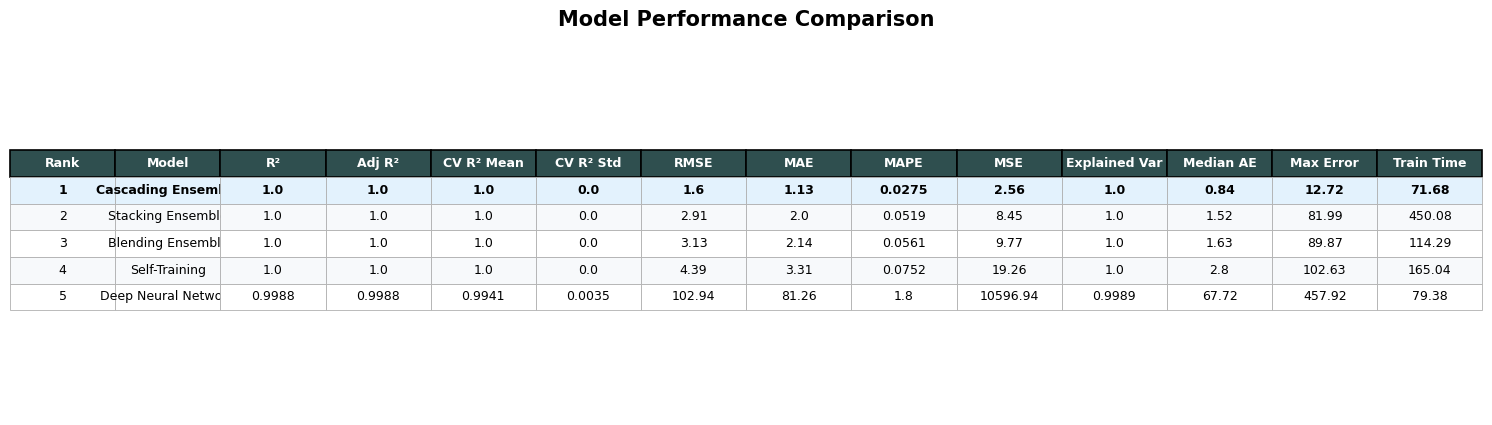

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Data
# ---------------------------
df = pd.DataFrame({
    "Rank": [1, 2, 3, 4, 5],
    "Model": [
        "Cascading Ensemble",
        "Stacking Ensemble",
        "Blending Ensemble",
        "Self-Training",
        "Deep Neural Network"
    ],
    "R²": [1.0, 0.999999, 0.999999, 0.999998, 0.998812],
    "Adj R²": [1.0, 0.999999, 0.999999, 0.999998, 0.998811],
    "CV R² Mean": [1.0, 0.999999, 0.999999, 0.999999, 0.994069],
    "CV R² Std": [0.0, 1e-6, 1e-6, 0.0, 0.003531],
    "RMSE": [1.6, 2.91, 3.13, 4.39, 102.94],
    "MAE": [1.13, 2.0, 2.14, 3.31, 81.26],
    "MAPE": [0.027458, 0.051927, 0.056051, 0.075235, 1.8],
    "MSE": [2.56, 8.45, 9.77, 19.26, 10596.94],
    "Explained Var": [1.0, 0.999999, 0.999999, 0.999998, 0.998935],
    "Median AE": [0.84, 1.52, 1.63, 2.8, 67.72],
    "Max Error": [12.72, 81.99, 89.87, 102.63, 457.92],
    "Train Time": [71.68, 450.08, 114.29, 165.04, 79.38],
})

# Round numeric values for cleaner display
df = df.round(4)

# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(19, 4.8))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="center",
    loc="center"
)

# ---------------------------
# Styling
# ---------------------------
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.6)

header_color = "#2F4F4F"
header_text_color = "white"
row_colors = ["#F7F9FB", "white"]
best_model_color = "#E3F2FD"

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color, weight="bold")
        cell.set_edgecolor("black")
        cell.set_linewidth(1.2)
    else:
        # Zebra striping
        cell.set_facecolor(row_colors[row % 2])
        cell.set_edgecolor("#B0B0B0")
        cell.set_linewidth(0.6)

        # Highlight best-performing model (Rank 1)
        if row == 1:
            cell.set_facecolor(best_model_color)
            cell.set_text_props(weight="bold")

# Title
plt.title(
    "Model Performance Comparison",
    fontsize=15,
    weight="bold",
    pad=14
)

# Save high-quality output
plt.savefig(
    "model_performance_table_enhanced.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()


SMART GRID RESEARCH - INTERACTIVE PLOT VIEWER

✓ Found 12 plot files in 'ieee_plots/'

PLOT VIEWER MENU

📊 Available Options:

  1. View ALL plots (Comprehensive Overview)
  2. View Model Comparison Plots
  3. View Residual Analysis Plots (All 5 Models)
  4. View Training History Plots
  5. View Error Distribution Plots
  6. View Individual Plots (List All)
  7. View Plots by Model Name
  8. Display All Plots in Grid
  9. Show Plot Statistics
  10. Create ZIP file of all plots
  0. Exit


Enter your choice (0-10): 1

📊 Displaying all 12 plots...


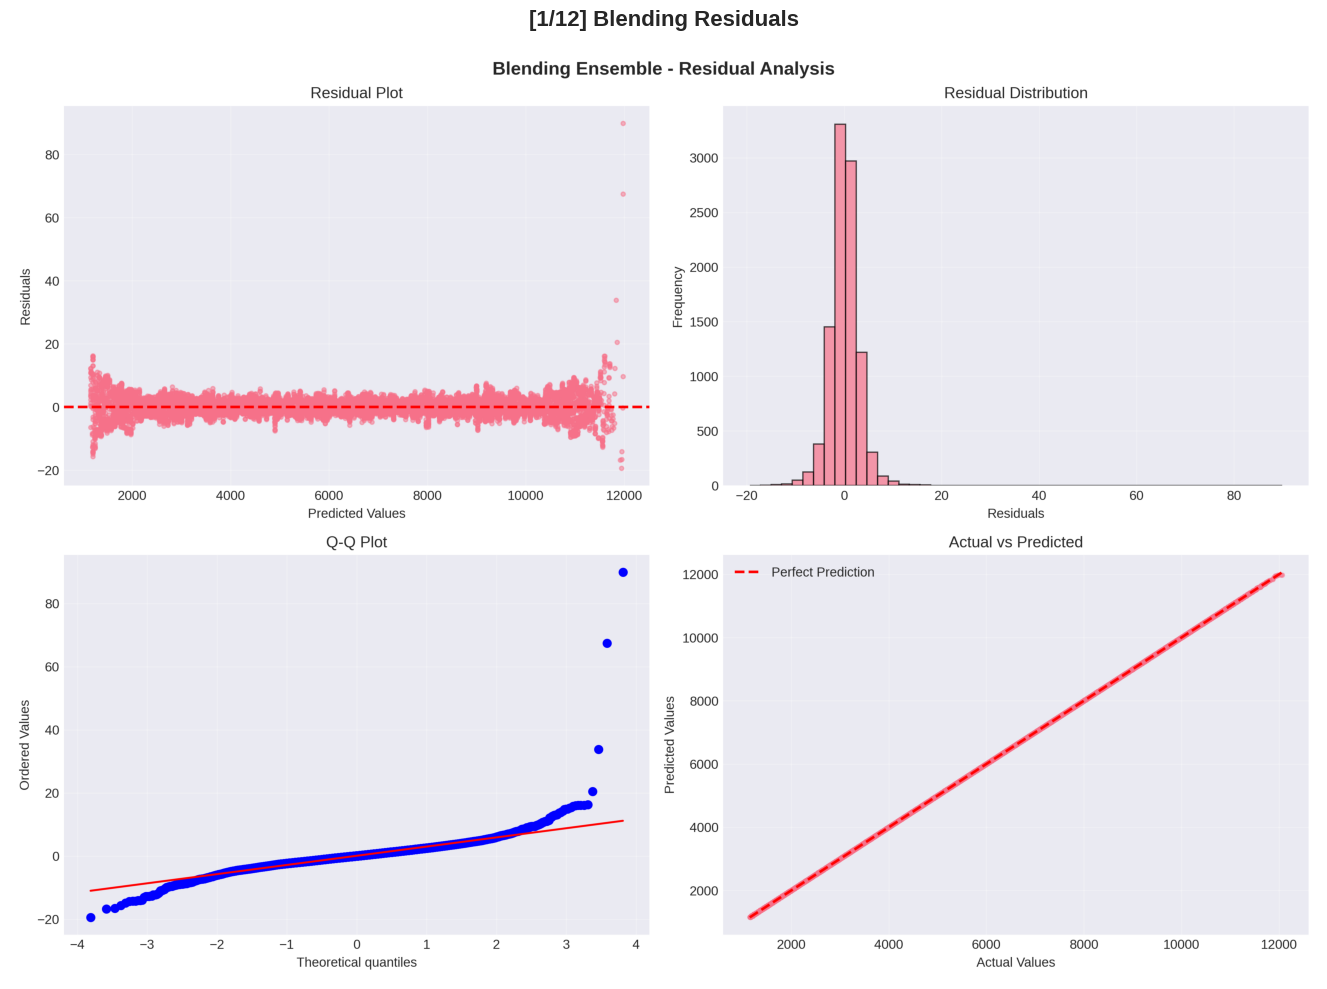

✓ Displayed: [1/12] Blending Residuals


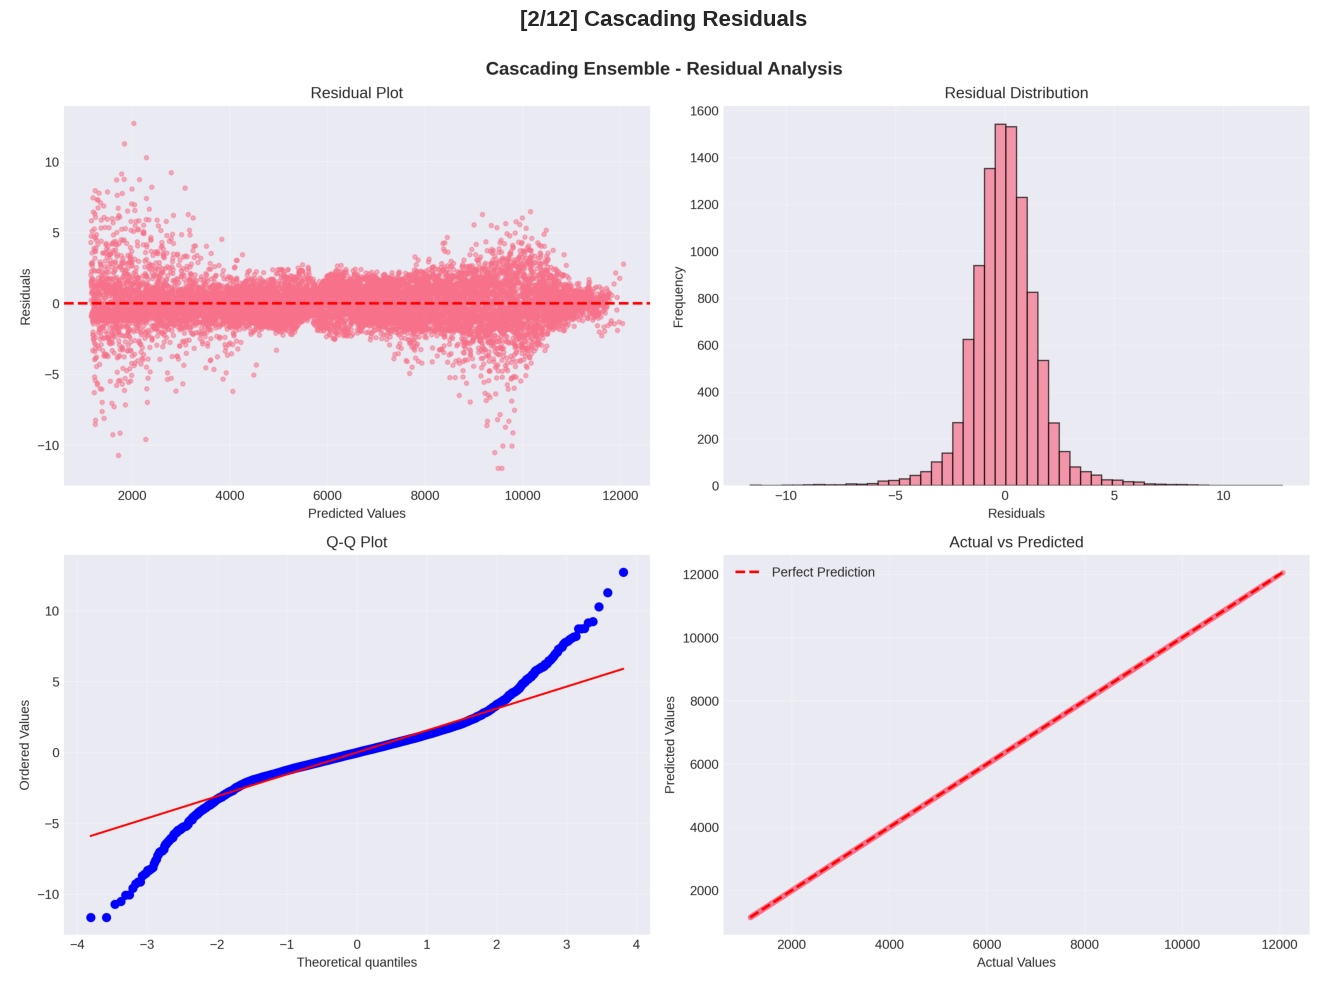

✓ Displayed: [2/12] Cascading Residuals


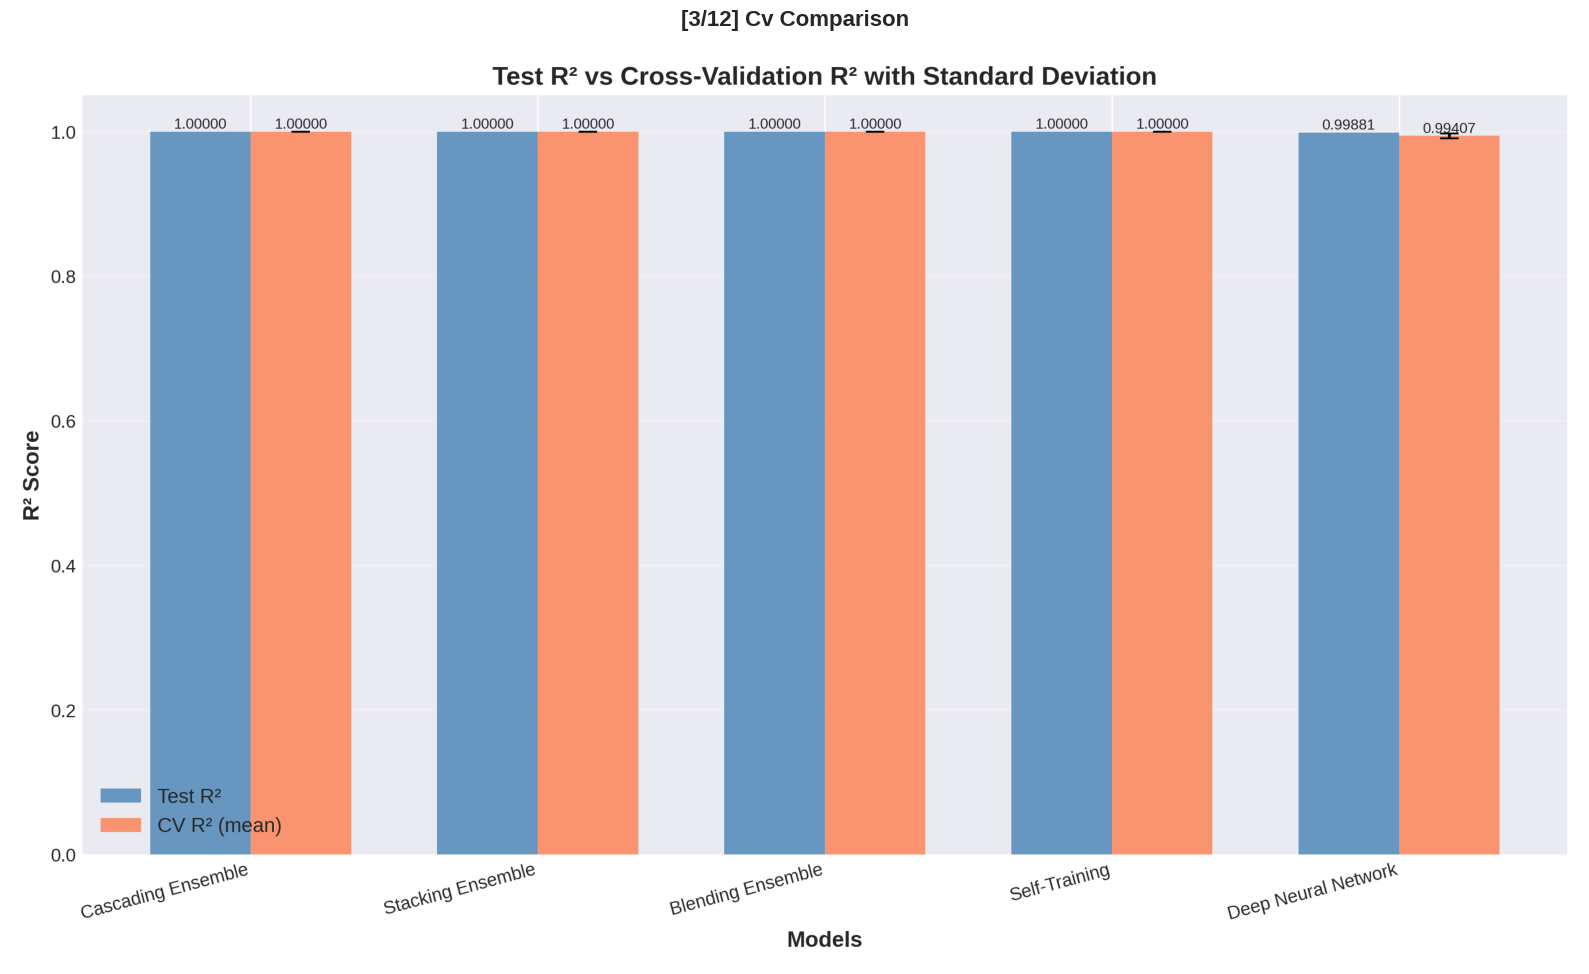

✓ Displayed: [3/12] Cv Comparison


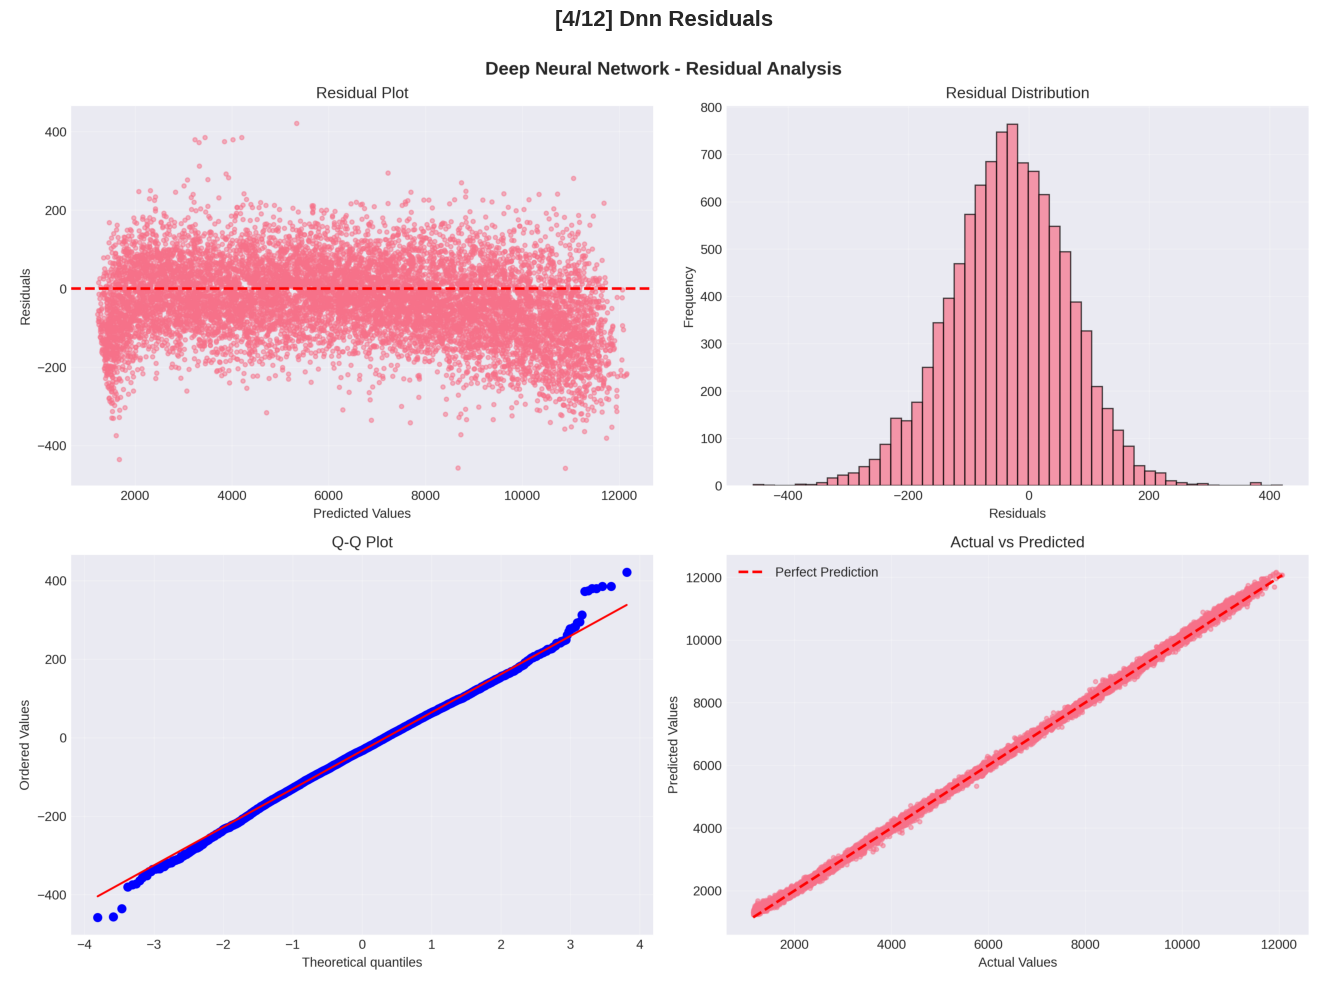

✓ Displayed: [4/12] Dnn Residuals


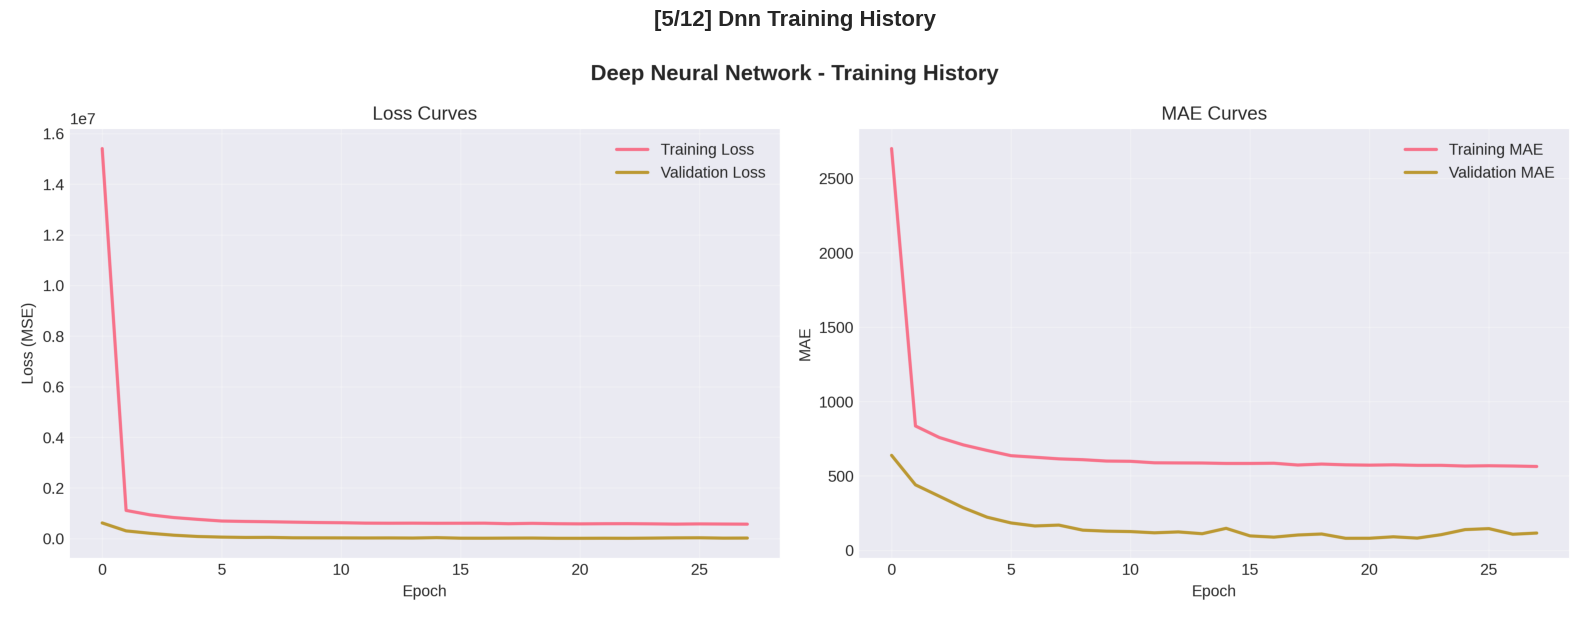

✓ Displayed: [5/12] Dnn Training History


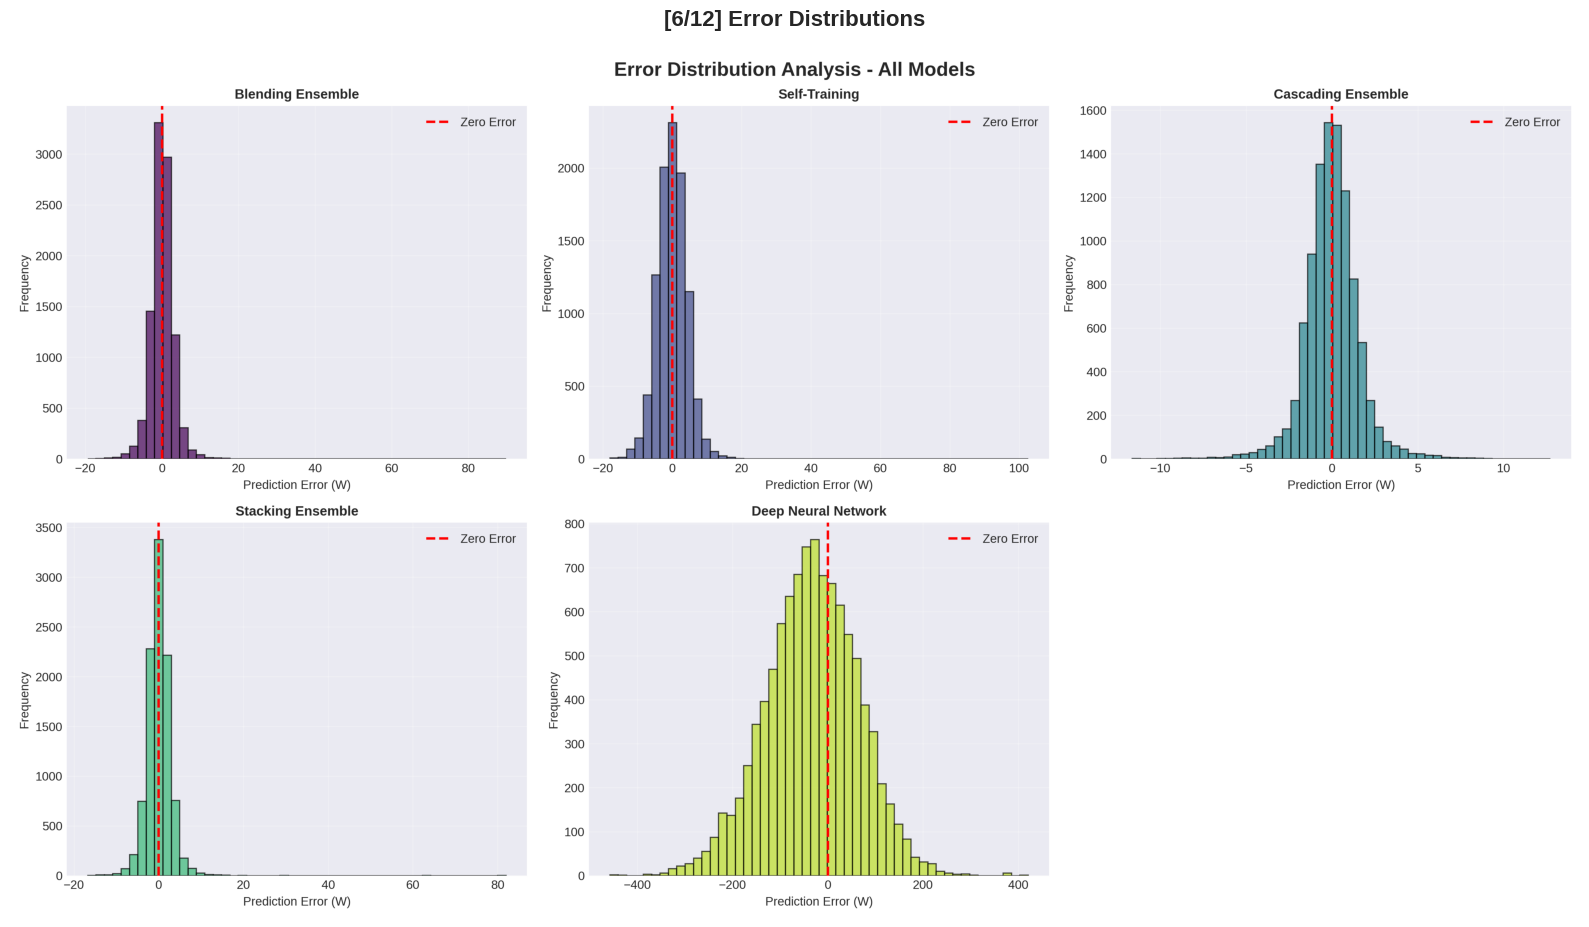

✓ Displayed: [6/12] Error Distributions


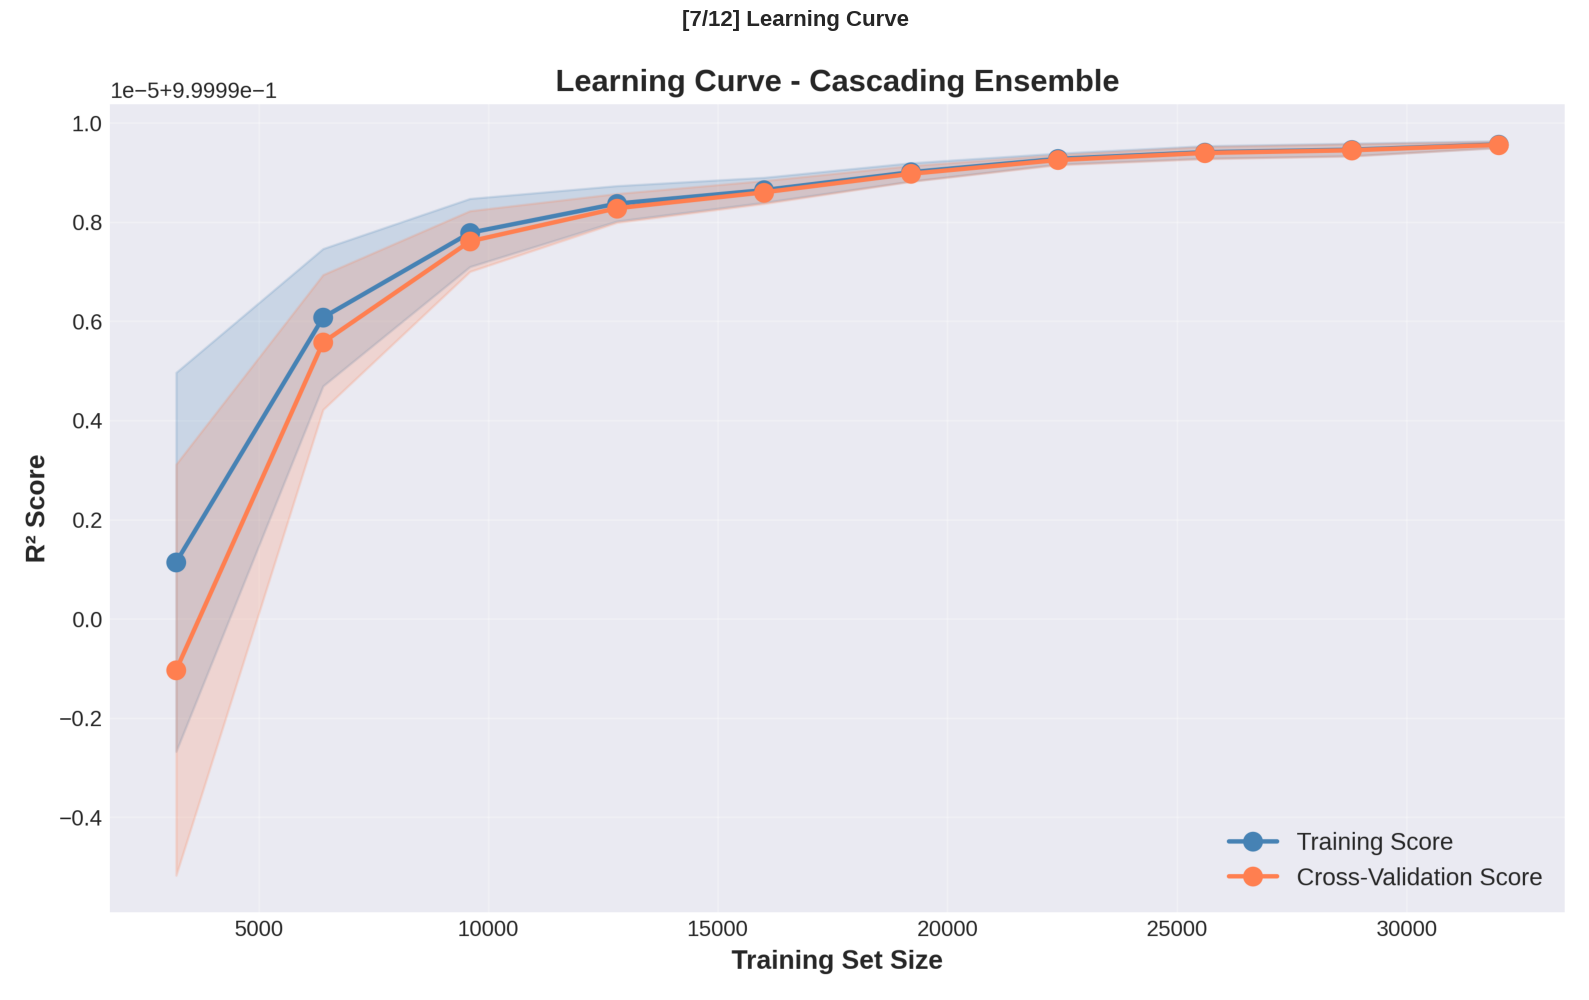

✓ Displayed: [7/12] Learning Curve


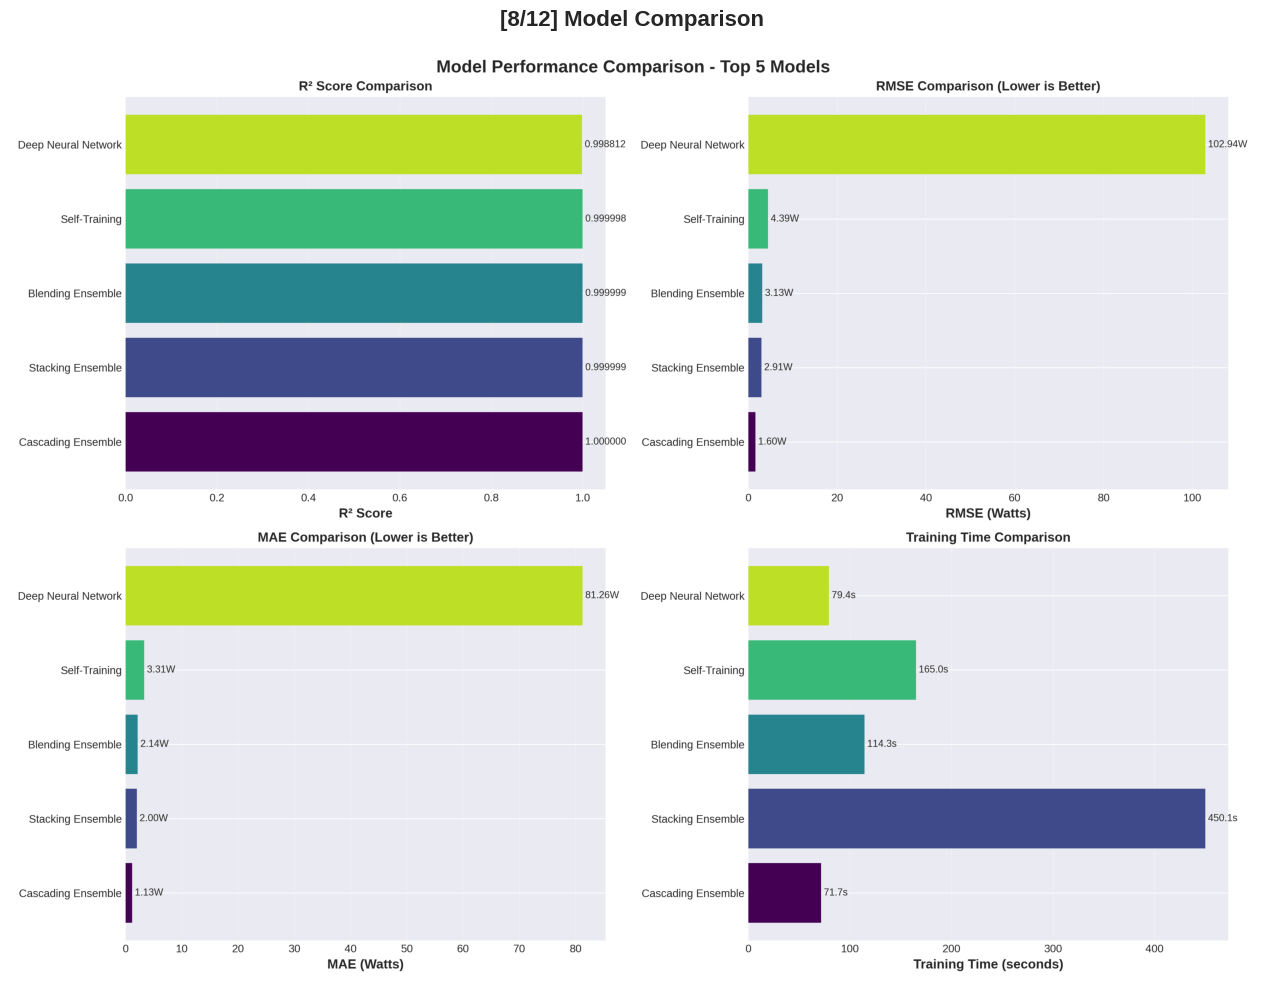

✓ Displayed: [8/12] Model Comparison


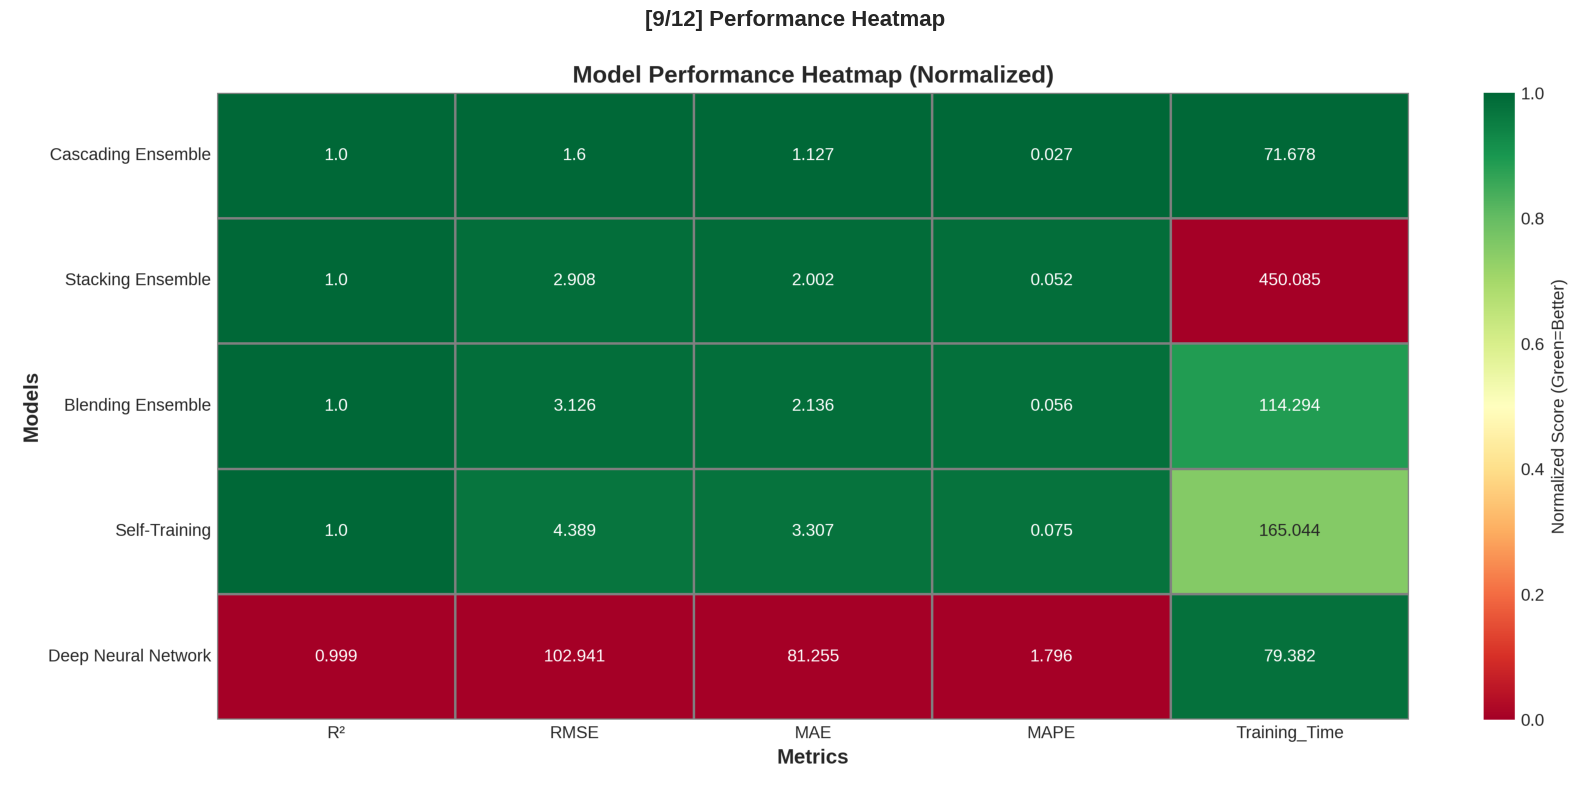

✓ Displayed: [9/12] Performance Heatmap


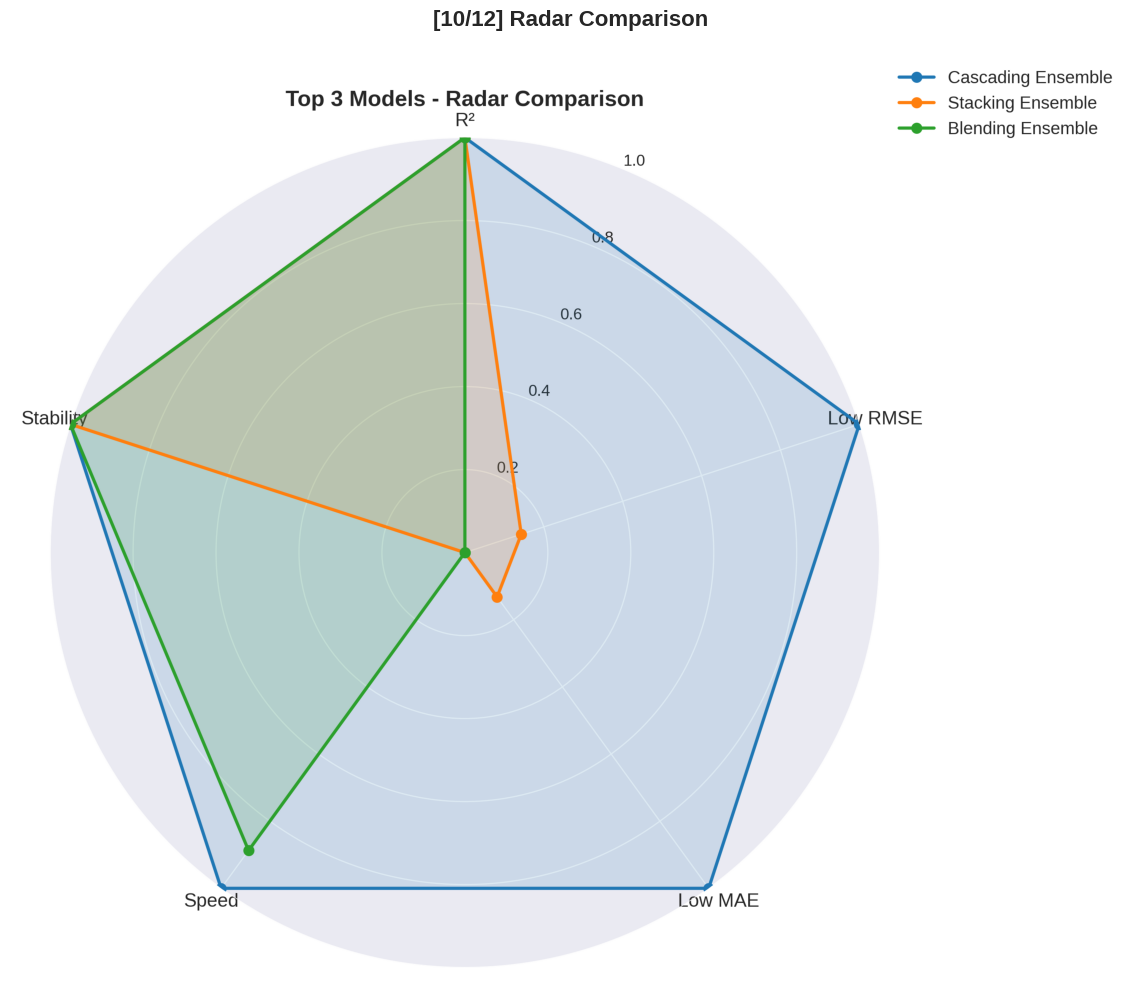

✓ Displayed: [10/12] Radar Comparison


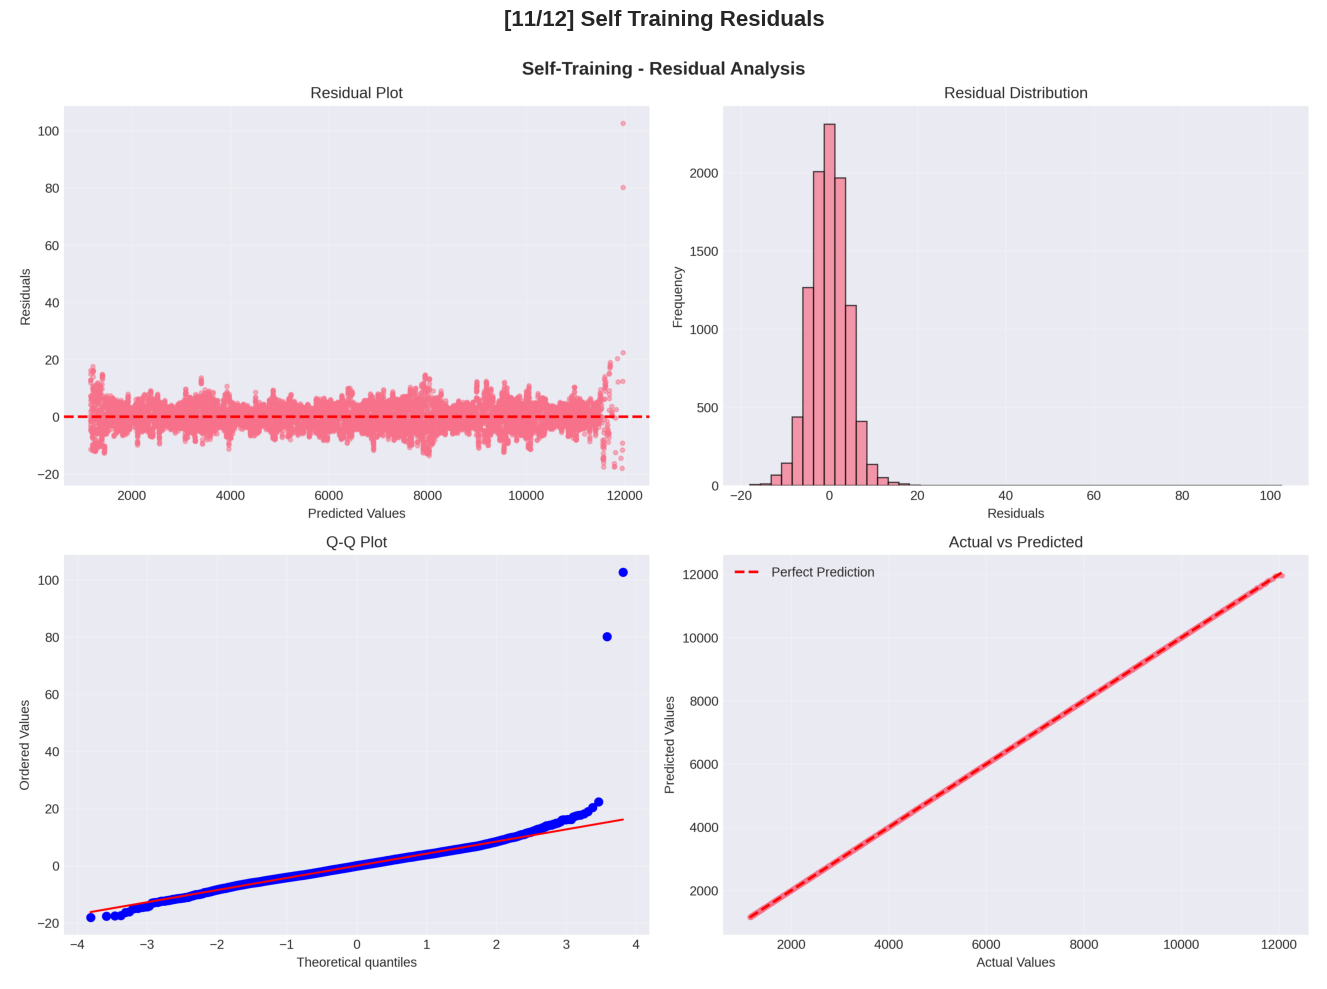

✓ Displayed: [11/12] Self Training Residuals


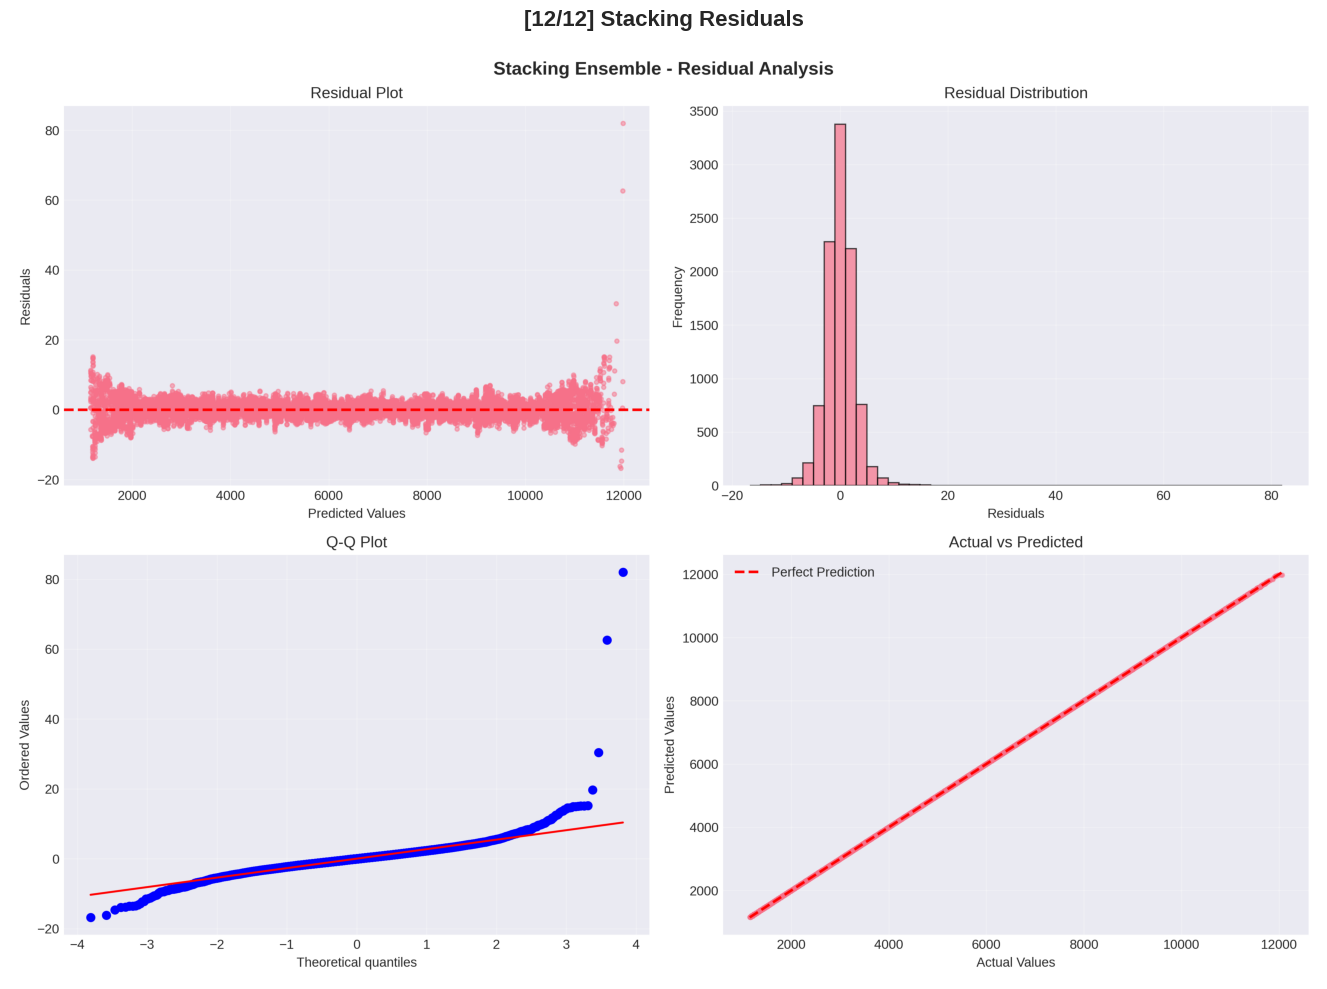

✓ Displayed: [12/12] Stacking Residuals

✓ Displayed all 12 plots

Press Enter to continue...2

PLOT VIEWER MENU

📊 Available Options:

  1. View ALL plots (Comprehensive Overview)
  2. View Model Comparison Plots
  3. View Residual Analysis Plots (All 5 Models)
  4. View Training History Plots
  5. View Error Distribution Plots
  6. View Individual Plots (List All)
  7. View Plots by Model Name
  8. Display All Plots in Grid
  9. Show Plot Statistics
  10. Create ZIP file of all plots
  0. Exit


Enter your choice (0-10): 3

📊 Found 5 residual analysis plots:
  1. blending_residuals.png
  2. cascading_residuals.png
  3. dnn_residuals.png
  4. self_training_residuals.png
  5. stacking_residuals.png

📊 Displaying all residual plots...


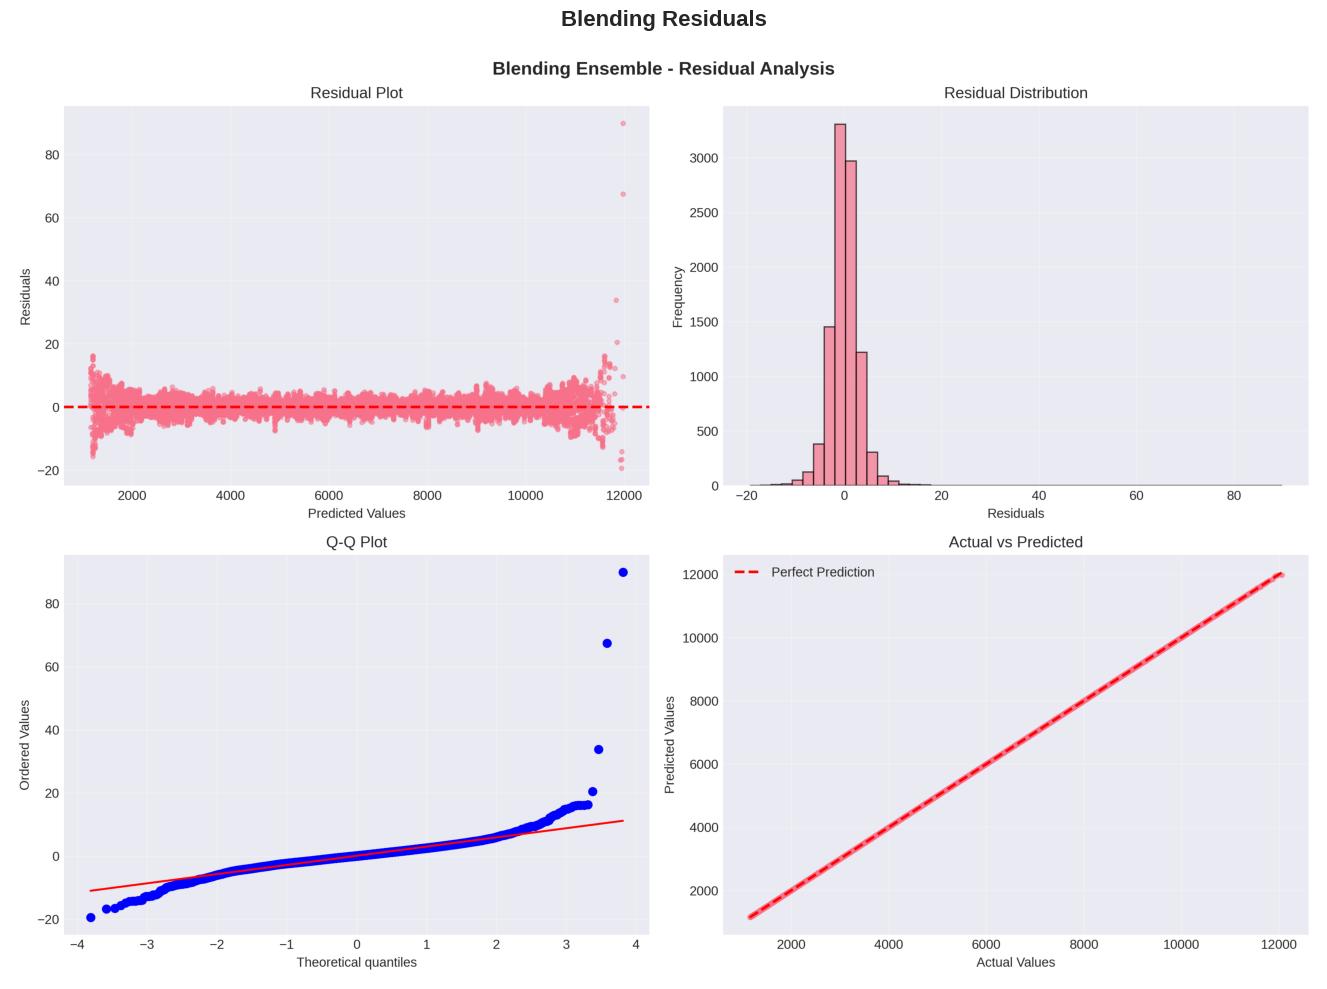

✓ Displayed: Blending Residuals


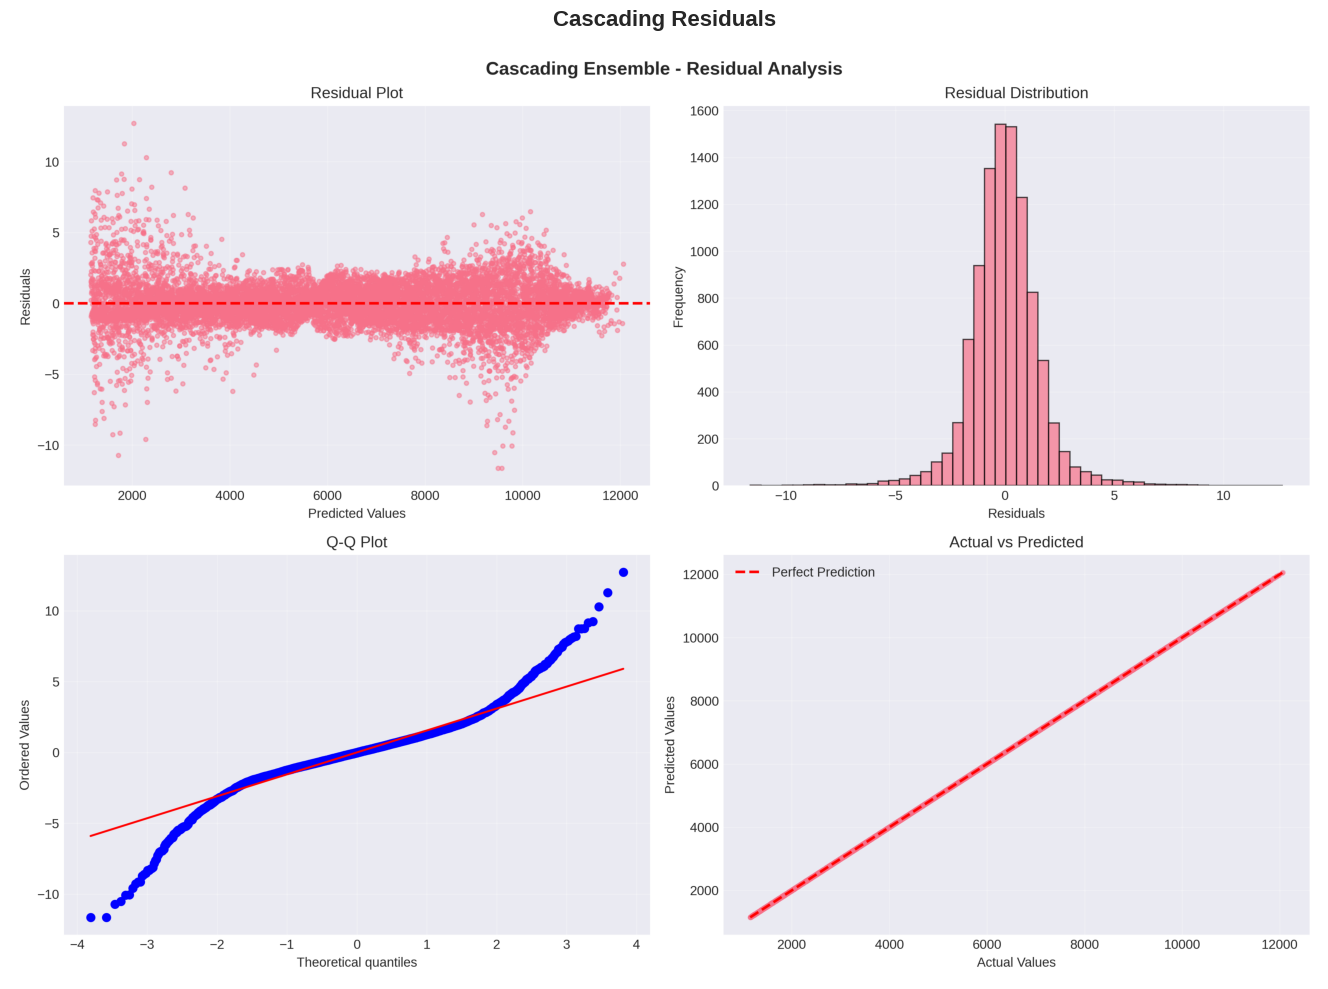

✓ Displayed: Cascading Residuals


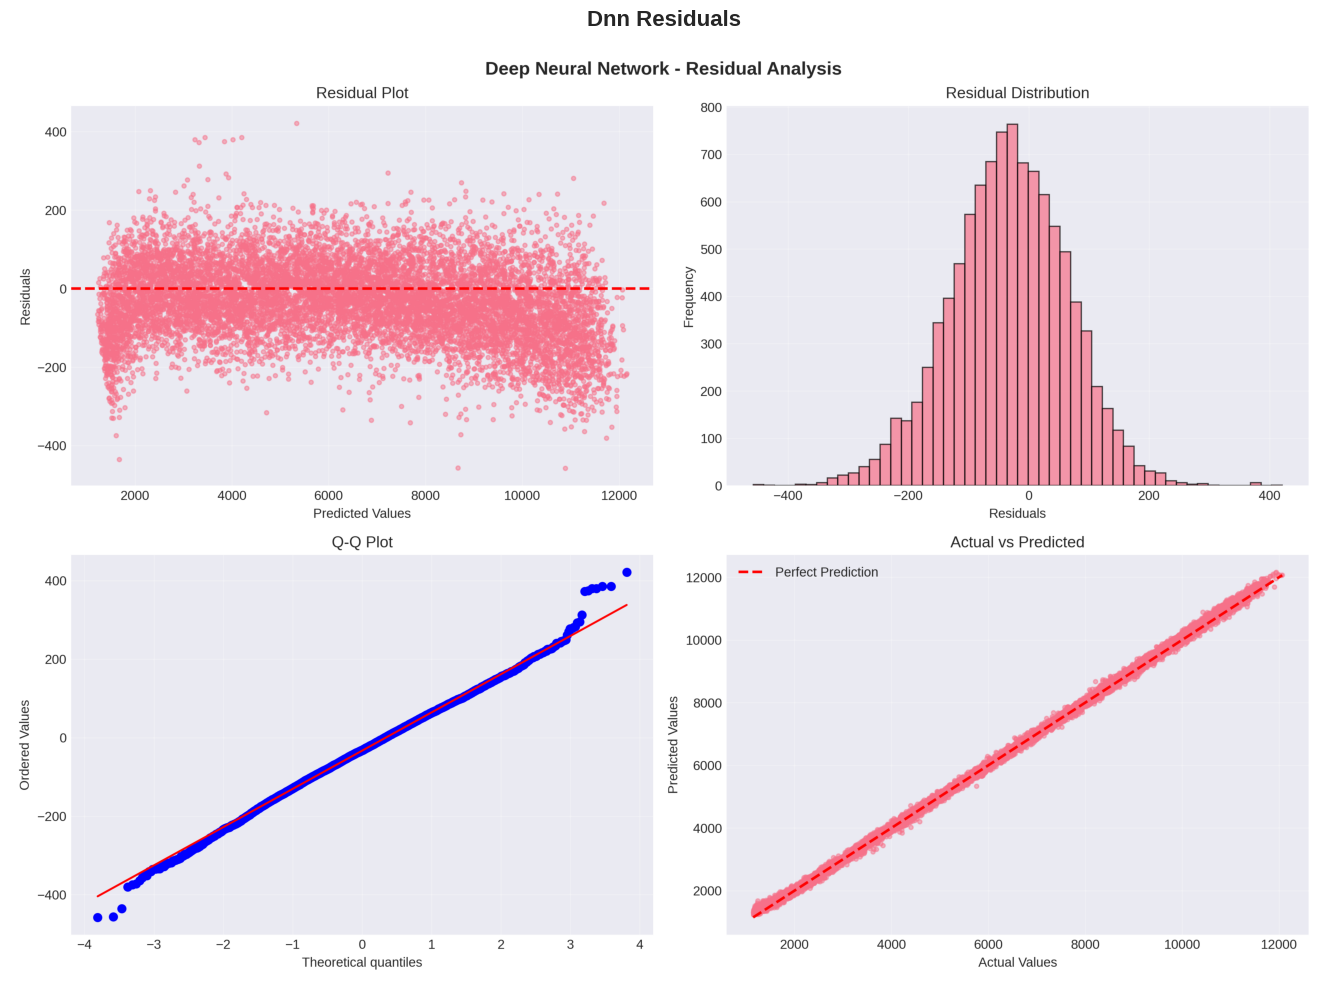

✓ Displayed: Dnn Residuals


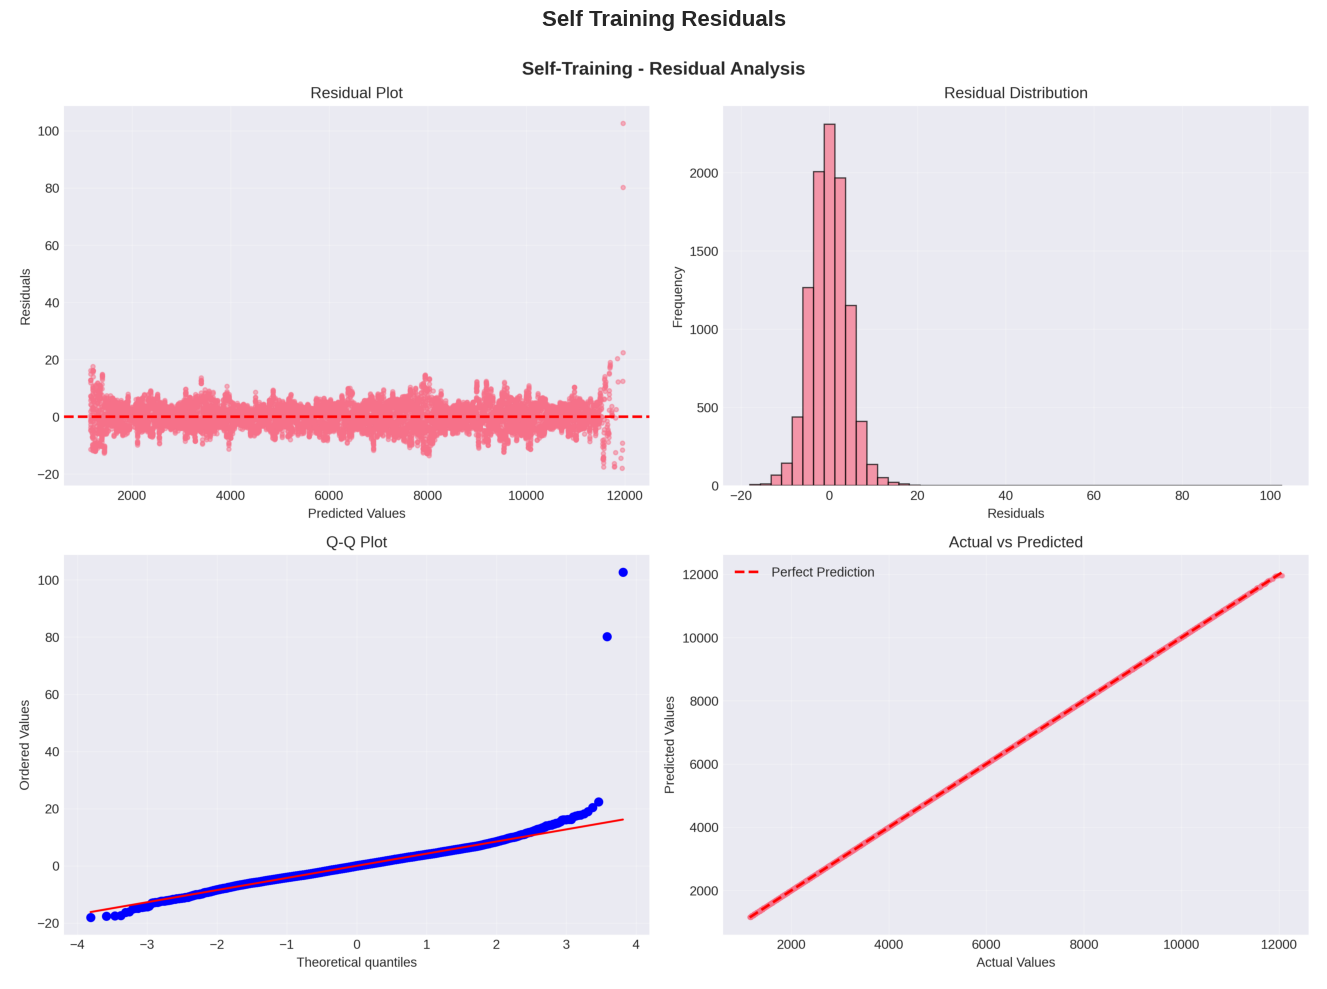

✓ Displayed: Self Training Residuals


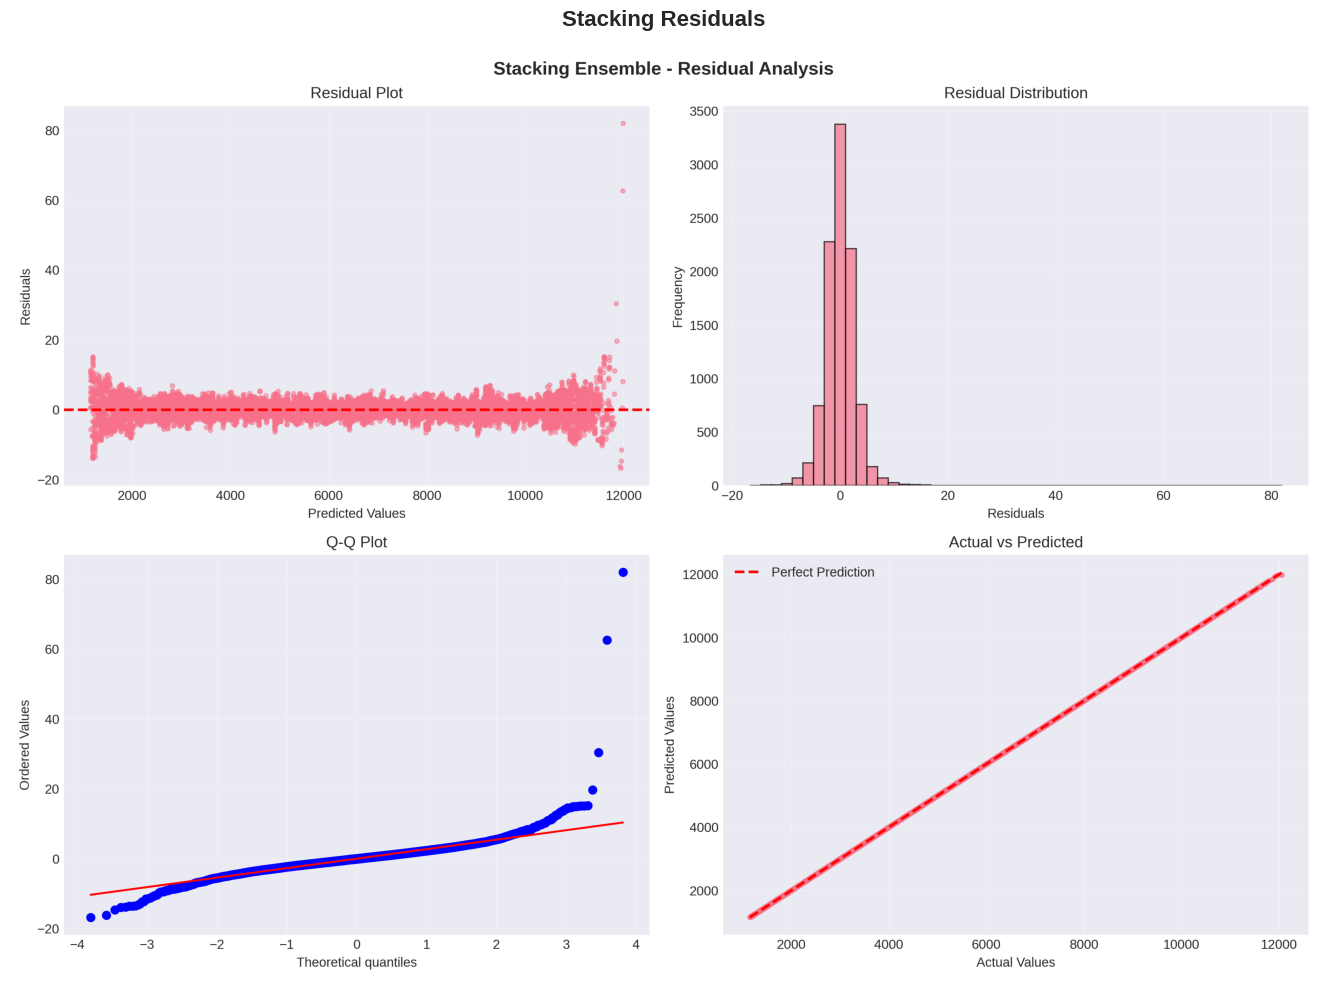

✓ Displayed: Stacking Residuals

✓ Displayed 5 residual plots

Press Enter to continue...4

PLOT VIEWER MENU

📊 Available Options:

  1. View ALL plots (Comprehensive Overview)
  2. View Model Comparison Plots
  3. View Residual Analysis Plots (All 5 Models)
  4. View Training History Plots
  5. View Error Distribution Plots
  6. View Individual Plots (List All)
  7. View Plots by Model Name
  8. Display All Plots in Grid
  9. Show Plot Statistics
  10. Create ZIP file of all plots
  0. Exit


Enter your choice (0-10): 6

📊 Available Plots:
  1. blending_residuals.png
  2. cascading_residuals.png
  3. cv_comparison.png
  4. dnn_residuals.png
  5. dnn_training_history.png
  6. error_distributions.png
  7. learning_curve.png
  8. model_comparison.png
  9. performance_heatmap.png
  10. radar_comparison.png
  11. self_training_residuals.png
  12. stacking_residuals.png

Enter plot numbers to view (comma-separated, e.g., 1,3,5)
Or press Enter to go back

Your choice: 7


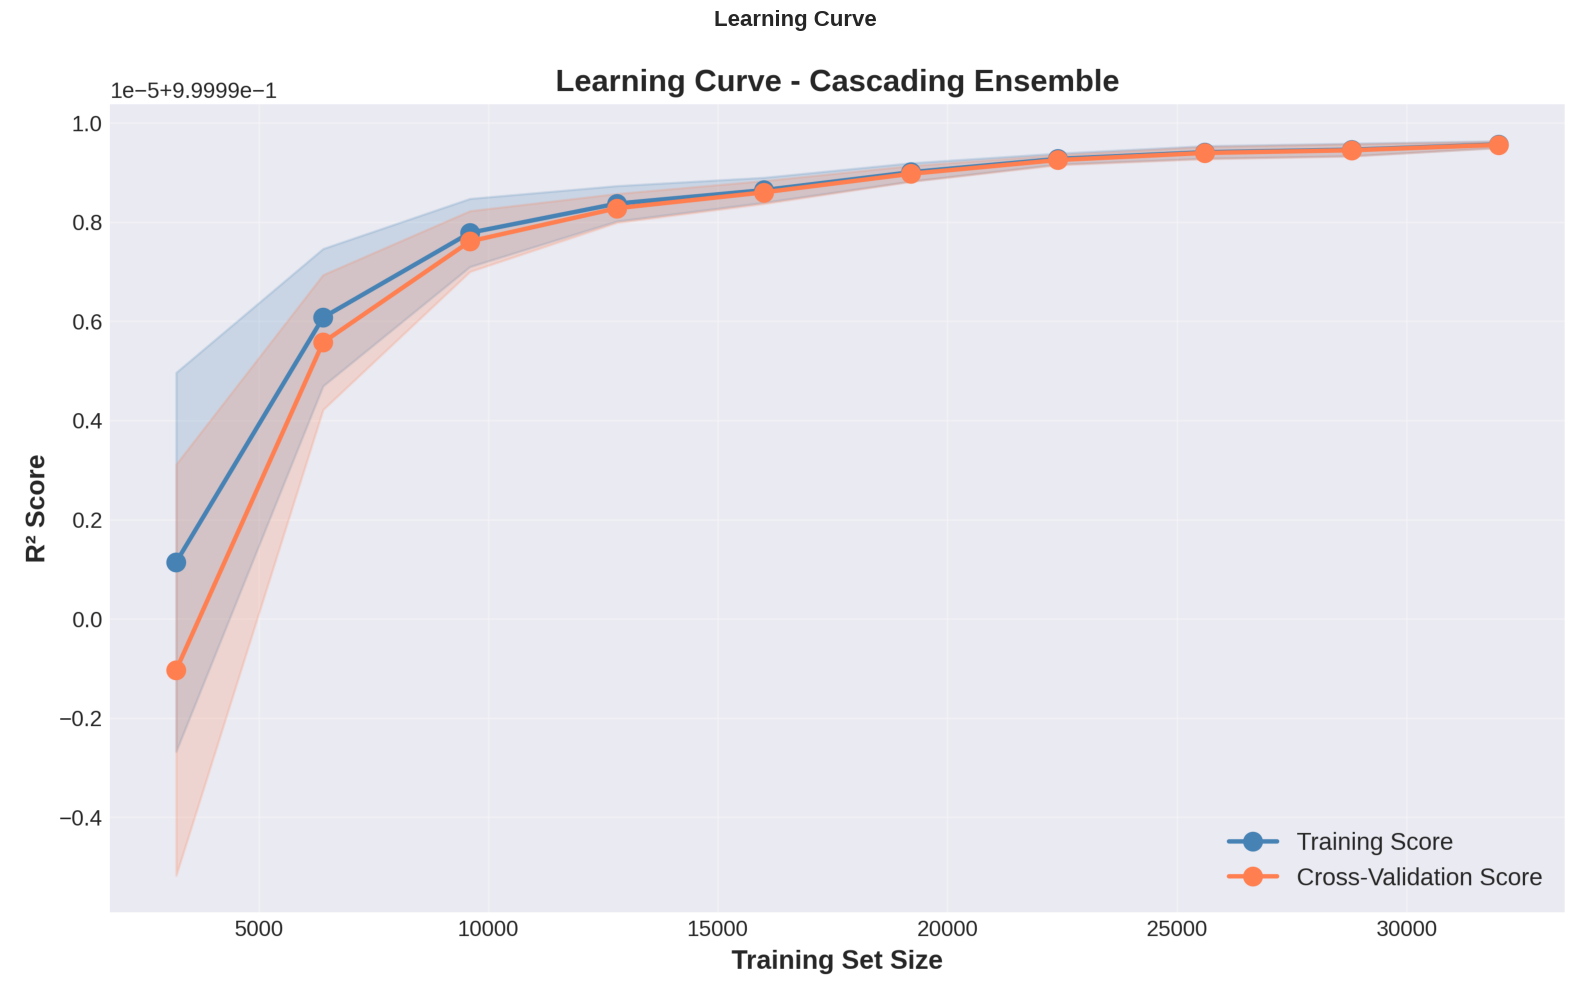

✓ Displayed: Learning Curve

Press Enter to continue...8

PLOT VIEWER MENU

📊 Available Options:

  1. View ALL plots (Comprehensive Overview)
  2. View Model Comparison Plots
  3. View Residual Analysis Plots (All 5 Models)
  4. View Training History Plots
  5. View Error Distribution Plots
  6. View Individual Plots (List All)
  7. View Plots by Model Name
  8. Display All Plots in Grid
  9. Show Plot Statistics
  10. Create ZIP file of all plots
  0. Exit


Enter your choice (0-10): 9

PLOT STATISTICS

📊 Total Plots: 12

📁 Plot Categories:
   • Model Comparison Plots: 4
   • Residual Analysis Plots: 5
   • Training History Plots: 3
   • Error Distribution Plots: 1
   • Other Plots: 0

📋 All Plot Files:
    1. blending_residuals.png                             (  484.9 KB)
    2. cascading_residuals.png                            (  814.3 KB)
    3. cv_comparison.png                                  (  202.0 KB)
    4. dnn_residuals.png                                  ( 1319.2 KB)
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started! Check your browser's download folder.

Press Enter to continue...0

PLOT VIEWER MENU

📊 Available Options:

  1. View ALL plots (Comprehensive Overview)
  2. View Model Comparison Plots
  3. View Residual Analysis Plots (All 5 Models)
  4. View Training History Plots
  5. View Error Distribution Plots
  6. View Individual Plots (List All)
  7. View Plots by Model Name
  8. Display All Plots in Grid
  9. Show Plot Statistics
  10. Create ZIP file of all plots
  0. Exit


Enter your choice (0-10): 0

👋 Exiting Plot Viewer. Thank you!


In [ ]:
"""
================================================================================
Interactive Plot Viewer - IEEE Smart Grid Research Results
================================================================================
Interactive menu-driven script to view specific plots or all plots
Run this AFTER running the main ieee_smart_grid_enhanced.py script
================================================================================
"""

import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("="*80)
print("SMART GRID RESEARCH - INTERACTIVE PLOT VIEWER")
print("="*80)

# Define plot directory
PLOT_DIR = 'ieee_plots'

# Check if directory exists
if not os.path.exists(PLOT_DIR):
    print(f"\n❌ Error: Directory '{PLOT_DIR}' not found!")
    print("Please run 'ieee_smart_grid_enhanced.py' first to generate plots.")
    exit()

# Get all plot files
plot_files = sorted([f for f in os.listdir(PLOT_DIR) if f.endswith('.png')])

if not plot_files:
    print(f"\n❌ Error: No plot files found in '{PLOT_DIR}'!")
    print("Please run 'ieee_smart_grid_enhanced.py' first to generate plots.")
    exit()

print(f"\n✓ Found {len(plot_files)} plot files in '{PLOT_DIR}/'")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def display_plot(filepath, title):
    """Display a single plot"""
    try:
        img = Image.open(filepath)
        plt.figure(figsize=(16, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        print(f"✓ Displayed: {title}")
    except Exception as e:
        print(f"❌ Error displaying {filepath}: {e}")

def display_multiple_plots(filepaths, titles, grid_size=(2, 2)):
    """Display multiple plots in a grid"""
    rows, cols = grid_size
    n_plots = len(filepaths)

    fig = plt.figure(figsize=(20, 16))

    for idx, (filepath, title) in enumerate(zip(filepaths, titles)):
        if idx >= rows * cols:
            break
        try:
            img = Image.open(filepath)
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(title, fontsize=11, fontweight='bold')
        except Exception as e:
            print(f"❌ Error loading {filepath}: {e}")

    plt.tight_layout()
    plt.show()

# ============================================================================
# CATEGORIZE PLOTS
# ============================================================================

residual_plots = [f for f in plot_files if 'residual' in f.lower()]
comparison_plots = [f for f in plot_files if any(x in f.lower() for x in ['comparison', 'heatmap', 'radar', 'cv_comparison'])]
training_plots = [f for f in plot_files if 'training' in f.lower() or 'learning' in f.lower()]
error_plots = [f for f in plot_files if 'error' in f.lower() and 'residual' not in f.lower()]
other_plots = [f for f in plot_files if f not in residual_plots + comparison_plots + training_plots + error_plots]

# ============================================================================
# MENU FUNCTIONS
# ============================================================================

def show_menu():
    """Display main menu"""
    print("\n" + "="*80)
    print("PLOT VIEWER MENU")
    print("="*80)
    print("\n📊 Available Options:")
    print("\n  1. View ALL plots (Comprehensive Overview)")
    print("  2. View Model Comparison Plots")
    print(f"  3. View Residual Analysis Plots (All {len(residual_plots)} Models)")
    print("  4. View Training History Plots")
    print("  5. View Error Distribution Plots")
    print("  6. View Individual Plots (List All)")
    print("  7. View Plots by Model Name")
    print("  8. Display All Plots in Grid")
    print("  9. Show Plot Statistics")
    print("  10. Create ZIP file of all plots")
    print("  0. Exit")
    print("\n" + "="*80)

def view_all_plots():
    """View all plots one by one"""
    print(f"\n📊 Displaying all {len(plot_files)} plots...")
    for i, plot_file in enumerate(plot_files, 1):
        plot_path = os.path.join(PLOT_DIR, plot_file)
        title = f"[{i}/{len(plot_files)}] {plot_file.replace('_', ' ').replace('.png', '').title()}"
        display_plot(plot_path, title)
    print(f"\n✓ Displayed all {len(plot_files)} plots")

def view_comparison_plots():
    """View model comparison plots"""
    if not comparison_plots:
        print("\n⚠️  No comparison plots found")
        return

    print(f"\n📊 Displaying {len(comparison_plots)} comparison plots...")
    for plot_file in comparison_plots:
        plot_path = os.path.join(PLOT_DIR, plot_file)
        title = plot_file.replace('_', ' ').replace('.png', '').title()
        display_plot(plot_path, title)
    print(f"\n✓ Displayed {len(comparison_plots)} comparison plots")

def view_residual_plots():
    """View residual analysis plots"""
    if not residual_plots:
        print("\n⚠️  No residual analysis plots found")
        return

    print(f"\n📊 Found {len(residual_plots)} residual analysis plots:")
    for i, plot in enumerate(residual_plots, 1):
        print(f"  {i}. {plot}")

    print(f"\n📊 Displaying all residual plots...")
    for plot_file in residual_plots:
        plot_path = os.path.join(PLOT_DIR, plot_file)
        title = plot_file.replace('_', ' ').replace('.png', '').title()
        display_plot(plot_path, title)
    print(f"\n✓ Displayed {len(residual_plots)} residual plots")

def view_training_plots():
    """View training history plots"""
    if not training_plots:
        print("\n⚠️  No training history plots found")
        return

    print(f"\n📊 Displaying {len(training_plots)} training history plots...")
    for plot_file in training_plots:
        plot_path = os.path.join(PLOT_DIR, plot_file)
        title = plot_file.replace('_', ' ').replace('.png', '').title()
        display_plot(plot_path, title)
    print(f"\n✓ Displayed {len(training_plots)} training plots")

def view_error_plots():
    """View error distribution plots"""
    if not error_plots:
        print("\n⚠️  No error distribution plots found")
        return

    print(f"\n📊 Displaying {len(error_plots)} error distribution plots...")
    for plot_file in error_plots:
        plot_path = os.path.join(PLOT_DIR, plot_file)
        title = plot_file.replace('_', ' ').replace('.png', '').title()
        display_plot(plot_path, title)
    print(f"\n✓ Displayed {len(error_plots)} error plots")

def view_individual_plots():
    """View plots by selecting from list"""
    print("\n📊 Available Plots:")
    for i, plot in enumerate(plot_files, 1):
        print(f"  {i}. {plot}")

    print("\nEnter plot numbers to view (comma-separated, e.g., 1,3,5)")
    print("Or press Enter to go back")

    choice = input("\nYour choice: ").strip()

    if not choice:
        return

    try:
        indices = [int(x.strip()) - 1 for x in choice.split(',')]
        for idx in indices:
            if 0 <= idx < len(plot_files):
                plot_file = plot_files[idx]
                plot_path = os.path.join(PLOT_DIR, plot_file)
                title = plot_file.replace('_', ' ').replace('.png', '').title()
                display_plot(plot_path, title)
            else:
                print(f"⚠️  Invalid plot number: {idx + 1}")
    except ValueError:
        print("❌ Invalid input format")

def view_by_model():
    """View plots by model name"""
    models = ['blending', 'self_training', 'cascading', 'stacking', 'dnn']
    model_names = {
        'blending': 'Blending Ensemble',
        'self_training': 'Self-Training',
        'cascading': 'Cascading Ensemble',
        'stacking': 'Stacking Ensemble',
        'dnn': 'Deep Neural Network'
    }

    print("\n📊 Available Models:")
    for i, (key, name) in enumerate(model_names.items(), 1):
        count = len([f for f in plot_files if key in f.lower()])
        print(f"  {i}. {name} ({count} plots)")

    print("\nEnter model number (1-5) or press Enter to go back")
    choice = input("\nYour choice: ").strip()

    if not choice:
        return

    try:
        idx = int(choice) - 1
        if 0 <= idx < len(models):
            model_key = models[idx]
            model_plots = [f for f in plot_files if model_key in f.lower()]

            if not model_plots:
                print(f"\n⚠️  No plots found for {model_names[model_key]}")
                return

            print(f"\n📊 Displaying {len(model_plots)} plots for {model_names[model_key]}...")
            for plot_file in model_plots:
                plot_path = os.path.join(PLOT_DIR, plot_file)
                title = plot_file.replace('_', ' ').replace('.png', '').title()
                display_plot(plot_path, title)
            print(f"\n✓ Displayed {len(model_plots)} plots")
        else:
            print("❌ Invalid model number")
    except ValueError:
        print("❌ Invalid input")

def view_grid():
    """Display all plots in grid"""
    print(f"\n📊 Creating grid view with all {len(plot_files)} plots...")

    n_plots = len(plot_files)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig = plt.figure(figsize=(24, 8 * n_rows))
    fig.suptitle('Smart Grid Research - Complete Visualization Overview',
                 fontsize=20, fontweight='bold', y=0.995)

    for idx, plot_file in enumerate(plot_files, 1):
        try:
            img = Image.open(os.path.join(PLOT_DIR, plot_file))
            ax = fig.add_subplot(n_rows, n_cols, idx)
            ax.imshow(img)
            ax.axis('off')
            title = plot_file.replace('_', ' ').replace('.png', '').title()
            ax.set_title(title, fontsize=9, fontweight='bold')
        except Exception as e:
            print(f"❌ Error loading {plot_file}: {e}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.98)
    plt.show()
    print("\n✓ Grid view displayed")

def show_statistics():
    """Show plot statistics"""
    print("\n" + "="*80)
    print("PLOT STATISTICS")
    print("="*80)

    print(f"\n📊 Total Plots: {len(plot_files)}")
    print(f"\n📁 Plot Categories:")
    print(f"   • Model Comparison Plots: {len(comparison_plots)}")
    print(f"   • Residual Analysis Plots: {len(residual_plots)}")
    print(f"   • Training History Plots: {len(training_plots)}")
    print(f"   • Error Distribution Plots: {len(error_plots)}")
    print(f"   • Other Plots: {len(other_plots)}")

    print(f"\n📋 All Plot Files:")
    for i, plot in enumerate(plot_files, 1):
        size_kb = os.path.getsize(os.path.join(PLOT_DIR, plot)) / 1024
        print(f"   {i:2d}. {plot:<50s} ({size_kb:>7.1f} KB)")

    total_size_mb = sum(os.path.getsize(os.path.join(PLOT_DIR, f))
                        for f in plot_files) / (1024 * 1024)
    print(f"\n💾 Total Size: {total_size_mb:.2f} MB")
    print(f"📁 Location: {os.path.abspath(PLOT_DIR)}/")

def create_zip_file():
    """Create ZIP file of all plots"""
    import zipfile
    from datetime import datetime

    print("\n" + "="*80)
    print("CREATE ZIP FILE")
    print("="*80)

    # Create zip filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    zip_filename = f'ieee_plots_{timestamp}.zip'

    print(f"\n📦 Creating ZIP file: {zip_filename}")
    print("   This includes all plots from ieee_plots/ directory")
    print("   Please wait...")

    try:
        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for plot_file in plot_files:
                file_path = os.path.join(PLOT_DIR, plot_file)
                zipf.write(file_path, plot_file)
                print(f"   ✓ Added: {plot_file}")

            # Create a README
            readme_content = f"""
IEEE Smart Grid Research - Plots Package
=========================================

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Total Plots: {len(plot_files)}

Plot Categories:
• Model Comparison: {len(comparison_plots)} plots
• Residual Analysis: {len(residual_plots)} plots
• Training History: {len(training_plots)} plots
• Error Distribution: {len(error_plots)} plots

All plots are high-resolution (300 DPI) and IEEE publication-ready.

Contents:
{chr(10).join([f'  • {f}' for f in plot_files])}
"""
            zipf.writestr('README.txt', readme_content)
            print(f"   ✓ Added: README.txt")

        # Get zip file size
        zip_size_mb = os.path.getsize(zip_filename) / (1024 * 1024)

        print(f"\n✅ ZIP file created successfully!")
        print(f"   📦 Filename: {zip_filename}")
        print(f"   💾 Size: {zip_size_mb:.2f} MB")
        print(f"   📁 Location: {os.path.abspath(zip_filename)}")

        # Try to auto-download in Colab
        try:
            from google.colab import files
            print("\n🔽 Downloading file in Google Colab...")
            files.download(zip_filename)
            print("✅ Download started! Check your browser's download folder.")
        except ImportError:
            print("\n💡 ZIP file saved in current directory")

            # Try Jupyter download link
            try:
                from IPython.display import FileLink, display as ipydisplay
                print("\n🔗 Download link:")
                ipydisplay(FileLink(zip_filename))
            except ImportError:
                pass

    except Exception as e:
        print(f"\n❌ Error creating ZIP file: {e}")

# ============================================================================
# MAIN LOOP
# ============================================================================

def main():
    """Main program loop"""
    while True:
        show_menu()
        choice = input("\nEnter your choice (0-10): ").strip()

        if choice == '0':
            print("\n👋 Exiting Plot Viewer. Thank you!")
            break
        elif choice == '1':
            view_all_plots()
        elif choice == '2':
            view_comparison_plots()
        elif choice == '3':
            view_residual_plots()
        elif choice == '4':
            view_training_plots()
        elif choice == '5':
            view_error_plots()
        elif choice == '6':
            view_individual_plots()
        elif choice == '7':
            view_by_model()
        elif choice == '8':
            view_grid()
        elif choice == '9':
            show_statistics()
        elif choice == '10':
            create_zip_file()
        else:
            print("\n❌ Invalid choice. Please enter a number between 0-10.")

        input("\nPress Enter to continue...")

# ============================================================================
# RUN PROGRAM
# ============================================================================

if __name__ == "__main__":
    main()